In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.svm import SVR
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

In [3]:
!pip install keras
!pip install prophet

  Using cached prophet-1.1.5-py3-none-win_amd64.whl (13.3 MB)


### Data Sourcing

In [5]:
f_data = pd.read_csv("Finance_Data.csv")
e_data = pd.read_csv("Energy_Data.csv")
ev_data = pd.read_csv("Co2_Data.csv")

In [5]:
ev_data

ngfed_id        x       y  year  month   mean_xco2  mean_xco2_anomaly
0          241702 -179.875 -19.125  2020      4  411.570584           1.418393
1          241702 -179.875 -19.125  2020      6  411.295512           0.036626
2          241702 -179.875 -19.125  2021      1  412.019338           0.004017
3          241702 -179.875 -19.125  2020      5  411.227090           0.623775
4          241702 -179.875 -19.125  2020      7  411.735586           0.515591
...           ...      ...     ...   ...    ...         ...                ...
2089687     29332  179.875  68.875  2015      7  393.816748          -1.264323
2089688     28254  179.875  69.125  2017      6  408.099518           0.300650
2089689     21171  179.875  71.125  2016      6  407.036194           2.373563
2089690     21171  179.875  71.125  2017      6  406.808899          -0.855756
2089691     20475  179.875  71.375  2018      6  406.730591           0.741721

[2089692 rows x 7 columns]

In [6]:
f_data

Date  Close/Last     Open     High      Low
0     05/03/2024     5127.79  5122.78  5139.12  5101.22
1     05/02/2024     5064.20  5049.32  5073.21  5011.05
2     05/01/2024     5018.39  5029.03  5096.12  5013.45
3     04/30/2024     5035.69  5103.78  5110.83  5035.31
4     04/29/2024     5116.17  5114.13  5123.49  5088.65
...          ...         ...      ...      ...      ...
2526  05/12/2014     1896.65  1880.03  1897.13  1880.03
2527  05/09/2014     1878.48  1875.27  1878.57  1867.02
2528  05/08/2014     1875.63  1877.39  1889.07  1870.05
2529  05/07/2014     1878.21  1868.53  1878.83  1859.79
2530  05/06/2014     1867.72  1883.69  1883.69  1867.72

[2531 rows x 5 columns]

In [7]:
e_data

DateTime  Consumption  Production  Nuclear  Wind  \
0      2019-01-01 00:00:00         6352        6527     1395    79   
1      2019-01-01 01:00:00         6116        5701     1393    96   
2      2019-01-01 02:00:00         5873        5676     1393   142   
3      2019-01-01 03:00:00         5682        5603     1397   191   
4      2019-01-01 04:00:00         5557        5454     1393   159   
...                    ...          ...         ...      ...   ...   
46006  2024-03-31 19:00:00         5618        5902     1398   505   
46007  2024-03-31 20:00:00         6107        6205     1395   671   
46008  2024-03-31 21:00:00         5991        5855     1395   868   
46009  2024-03-31 22:00:00         5527        5726     1393   908   
46010  2024-03-31 23:00:00         5111        5551     1391  1011   

       Hydroelectric  Oil and Gas  Coal  Solar  Biomass  
0               1383         1896  1744      0       30  
1               1112         1429  1641      0       30  
2               1030         1465  1616      0       30  
3                972         1455  1558      0       30  
4                960         1454  1458      0       30  
...              ...          ...   ...    ...      ...  
46006           2294         1012   620      6       65  
46007           2389         1037   645      0       66  
46008           2201          705   621      0       66  
46009           2088          648   622      0       66  
46010           1845          633   607      0       66  

[46011 rows x 10 columns]

### Preprocessing

#### Finance Data

In [6]:
f_data.isnull().sum()  # Check for missing values
numeric_cols = ['Close/Last', 'Open', 'High', 'Low']
f_data[numeric_cols] = f_data[numeric_cols].fillna(f_data[numeric_cols].mean(), inplace=False)
scaler = StandardScaler()
f_data[['Close/Last', 'Open', 'High', 'Low']] = scaler.fit_transform(f_data[['Close/Last', 'Open', 'High', 'Low']])
f_data[['Close/Last', 'Open', 'High', 'Low']] = np.log(f_data[['Close/Last', 'Open', 'High', 'Low']])
f_data[numeric_cols] = f_data[numeric_cols].apply(pd.to_numeric, errors='coerce')
f_data = f_data.sort_values(by='Date')
f_data['Date'] = pd.to_datetime(f_data['Date'])
f_data_diff = f_data.diff().dropna()
f_data = f_data.dropna()
f_data['DateTime'] = pd.to_datetime(f_data['Date'])
f_data.set_index('DateTime', inplace=True)
f_data= f_data.sort_index()

C:\Users\hysam\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


#### Energy Data

In [7]:
e_data = e_data.sample(10000)
numeric_cols = ['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']
scaler = MinMaxScaler()
e_data[numeric_cols] = scaler.fit_transform(e_data[numeric_cols])
e_data[numeric_cols] = np.log(e_data[numeric_cols])
e_data['DateTime'] = pd.to_datetime(e_data['DateTime'])
e_data_diff = e_data.diff()[numeric_cols].dropna()
e_data = e_data.replace([np.inf, -np.inf], np.nan).dropna()
e_data['DateTime'] = pd.to_datetime(e_data['DateTime'])
e_data.set_index('DateTime', inplace=True)
e_data= e_data.sort_index()

C:\Users\hysam\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


#### Co2 Data

In [8]:
ev_data = ev_data.sample(10000)
ev_data.isnull().sum()
numeric_cols = ['x', 'y', 'mean_xco2', 'mean_xco2_anomaly']
ev_data[numeric_cols] = ev_data[numeric_cols].fillna(ev_data[numeric_cols].mean(), inplace=False)
scaler = MinMaxScaler()
ev_data[numeric_cols] = scaler.fit_transform(ev_data[numeric_cols])
ev_data[['mean_xco2', 'mean_xco2_anomaly']] = np.log(ev_data[['mean_xco2', 'mean_xco2_anomaly']])
ev_data_diff = ev_data.diff()[['mean_xco2', 'mean_xco2_anomaly']].dropna()
ev_data = ev_data.replace([np.inf, -np.inf], np.nan).dropna()
ev_data['Date'] = pd.to_datetime(ev_data['year'].astype(str) + '-' + ev_data['month'].astype(str))
ev_data.set_index('Date', inplace=True)
ev_data.drop(['year', 'month'], axis=1, inplace=True)
ev_data= ev_data.sort_index()

C:\Users\hysam\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


## Model Development

### Arima Model

#### Finance Data

Results of Dickey-Fuller Test:
Test Statistic                   -3.149069
p-value                           0.023129
#Lags Used                       16.000000
Number of Observations Used    1025.000000
Critical Value (1%)              -3.436746
Critical Value (5%)              -2.864364
Critical Value (10%)             -2.568274
dtype: float64


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


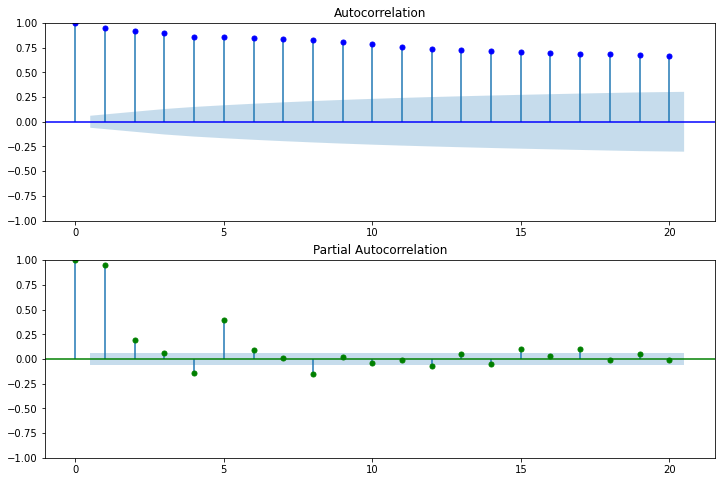

In [11]:
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    adf_result = adfuller(timeseries, autolag='AIC')
    result_series = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adf_result[4].items():
       result_series['Critical Value (%s)' % key] = value
    print(result_series)

adf_test(f_data['Close/Last'])

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(f_data['Close/Last'], lags=20, ax=axs[0], color='blue')
plot_pacf(f_data['Close/Last'], lags=20, ax=axs[1], color='green')
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                   -3.149069
p-value                           0.023129
#Lags Used                       16.000000
Number of Observations Used    1025.000000
Critical Value (1%)              -3.436746
Critical Value (5%)              -2.864364
Critical Value (10%)             -2.568274
dtype: float64


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


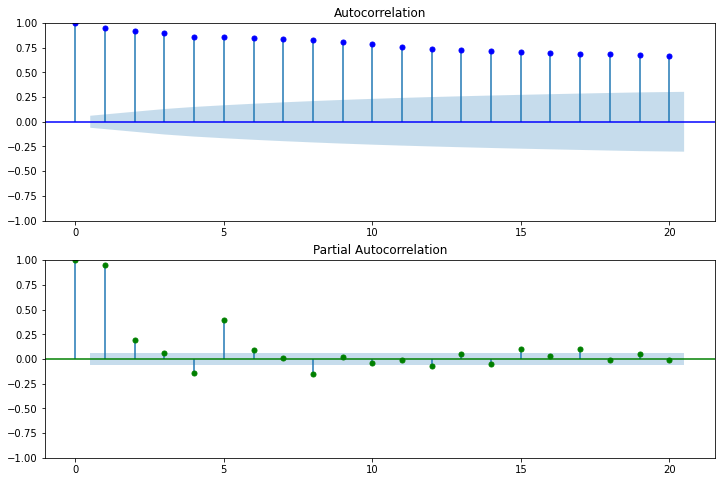

In [ ]:
import sqlite3
from io import BytesIO  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to perform the Augmented Dickey-Fuller test
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    adf_result = adfuller(timeseries, autolag='AIC')
    result_series = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adf_result[4].items():
        result_series['Critical Value (%s)' % key] = value
    print(result_series)

# Function to save the graph as an image file and return its binary data
def save_plot_to_bytes(figure):
    buffer = BytesIO()
    figure.savefig(buffer, format='png')
    buffer.seek(0)
    return buffer.read()

# Connect to SQLite database
conn = sqlite3.connect('arimafin.db')
cursor = conn.cursor()

# Create a table to store plots
cursor.execute('''CREATE TABLE IF NOT EXISTS plots (
                    id INTEGER PRIMARY KEY,
                    plot BLOB
                )''')

# Perform ADF test and save the plot
adf_test(f_data['Close/Last'])

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(f_data['Close/Last'], lags=20, ax=axs[0], color='blue')
plot_pacf(f_data['Close/Last'], lags=20, ax=axs[1], color='green')

# Save the plot as a binary object
plot_data = save_plot_to_bytes(fig)

# Insert the plot into the database
cursor.execute("INSERT INTO plots (plot) VALUES (?)", (sqlite3.Binary(plot_data),))
conn.commit()

# Close the cursor and connection
cursor.close()
conn.close()


Results of Dickey-Fuller Test:
Test Statistic                   -3.149069
p-value                           0.023129
#Lags Used                       16.000000
Number of Observations Used    1025.000000
Critical Value (1%)              -3.436746
Critical Value (5%)              -2.864364
Critical Value (10%)             -2.568274
dtype: float64


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


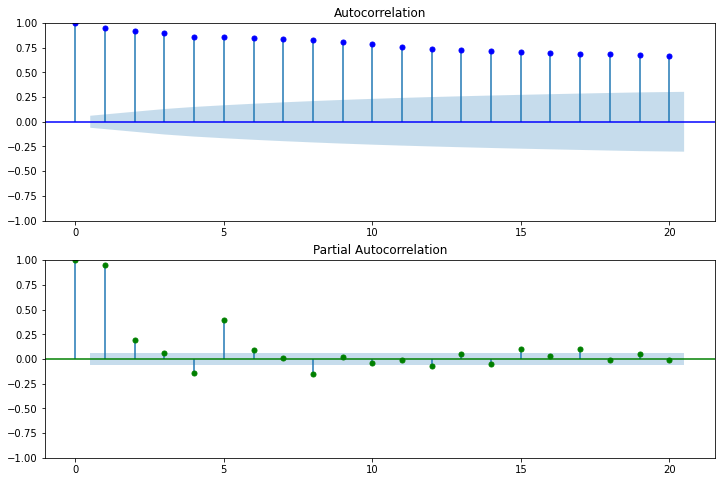

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    adf_result = adfuller(timeseries, autolag='AIC')
    result_series = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adf_result[4].items():
       result_series['Critical Value (%s)' % key] = value
    print(result_series)

adf_test(f_data['Close/Last'])

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(f_data['Close/Last'], lags=20, ax=axs[0], color='blue')
plot_pacf(f_data['Close/Last'], lags=20, ax=axs[1], color='green')

# Save the plot as 'arimafin.png'
plt.savefig('arimafin.png')

plt.show()


Results of Dickey-Fuller Test:
Test Statistic                   -3.149069
p-value                           0.023129
#Lags Used                       16.000000
Number of Observations Used    1025.000000
Critical Value (1%)              -3.436746
Critical Value (5%)              -2.864364
Critical Value (10%)             -2.568274
dtype: float64
ADF result saved to adf_result.pkl


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


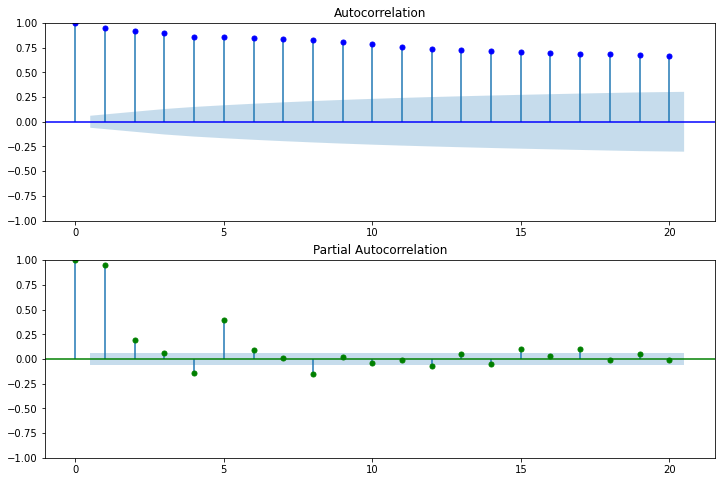

In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def adf_test_and_save(timeseries, filename):
    print('Results of Dickey-Fuller Test:')
    adf_result = adfuller(timeseries, autolag='AIC')
    result_series = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adf_result[4].items():
       result_series['Critical Value (%s)' % key] = value
    print(result_series)

    # Save the adf_result to a pickle file
    with open(filename, 'wb') as f:
        pickle.dump(adf_result, f)
    print("ADF result saved to", filename)

    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(timeseries, lags=20, ax=axs[0], color='blue')
    plot_pacf(timeseries, lags=20, ax=axs[1], color='green')
    plt.show()

# Example usage:
adf_test_and_save(f_data['Close/Last'], 'adf_result.pkl')


#### Energy Data

Results of Dickey-Fuller Test:
Test Statistic                   -5.621243
p-value                           0.000001
#Lags Used                       23.000000
Number of Observations Used    5135.000000
Critical Value (1%)              -3.431624
Critical Value (5%)              -2.862103
Critical Value (10%)             -2.567070
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -5.621243
p-value                           0.000001
#Lags Used                       23.000000
Number of Observations Used    5135.000000
Critical Value (1%)              -3.431624
Critical Value (5%)              -2.862103
Critical Value (10%)             -2.567070
dtype: float64


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


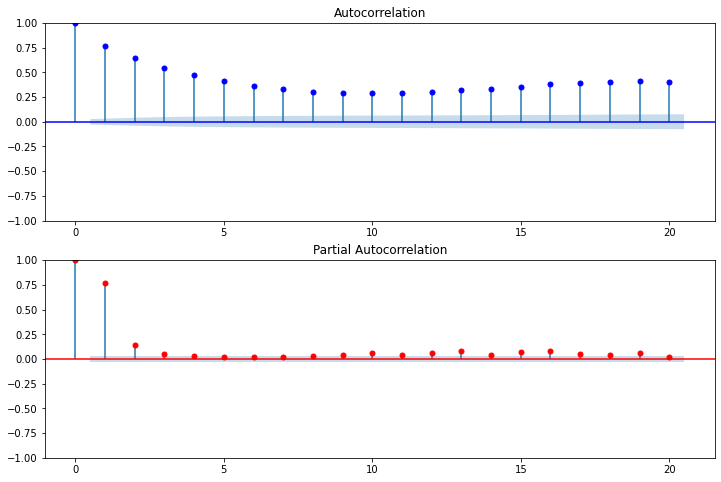

In [13]:
def adf_test(data_series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(data_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(e_data['Consumption'].values.reshape(-1, 1))
adf_test(scaled_data)
adf_test(e_data['Consumption'])
acf_color = 'blue'
pacf_color = 'red'
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(e_data['Consumption'], lags=20, ax=axs[0], color=acf_color)
plot_pacf(e_data['Consumption'], lags=20, ax=axs[1], color=pacf_color)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   -5.621243
p-value                           0.000001
#Lags Used                       23.000000
Number of Observations Used    5135.000000
Critical Value (1%)              -3.431624
Critical Value (5%)              -2.862103
Critical Value (10%)             -2.567070
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -5.621243
p-value                           0.000001
#Lags Used                       23.000000
Number of Observations Used    5135.000000
Critical Value (1%)              -3.431624
Critical Value (5%)              -2.862103
Critical Value (10%)             -2.567070
dtype: float64


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


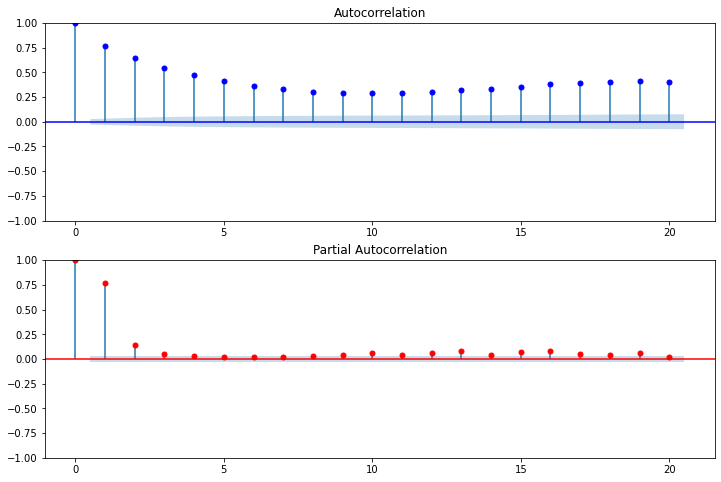

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler

def adf_test(data_series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(data_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(e_data['Consumption'].values.reshape(-1, 1))
adf_test(scaled_data)
adf_test(e_data['Consumption'])

acf_color = 'blue'
pacf_color = 'red'

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(e_data['Consumption'], lags=20, ax=axs[0], color=acf_color)
plot_pacf(e_data['Consumption'], lags=20, ax=axs[1], color=pacf_color)

# Save the plot as 'arimaene.png'
plt.savefig('arimaene.png')

plt.show()


In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from io import BytesIO
from sklearn.preprocessing import StandardScaler

# Function to perform the Augmented Dickey-Fuller test
def adf_test(data_series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(data_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Function to save the graph as an image file and return its binary data
def save_plot_to_bytes(figure):
    buffer = BytesIO()
    figure.savefig(buffer, format='png')
    buffer.seek(0)
    return buffer.read()

def store_plots_in_db(filename, data_series):
    # Connect to SQLite database
    conn = sqlite3.connect(filename)
    cursor = conn.cursor()

    # Create a table to store plots if not exists
    cursor.execute('''CREATE TABLE IF NOT EXISTS plots (
                        id INTEGER PRIMARY KEY,
                        plot BLOB
                    )''')

    # Perform ADF test and save the plot
    adf_test(data_series)

    # Plot ACF and PACF
    acf_color = 'blue'
    pacf_color = 'red'
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(data_series, lags=20, ax=axs[0], color=acf_color)
    plot_pacf(data_series, lags=20, ax=axs[1], color=pacf_color)
    plt.close()  # Close the plot to prevent displaying it

    # Save the plot as a binary object
    plot_data = save_plot_to_bytes(fig)

    # Insert the plot into the database
    cursor.execute("INSERT INTO plots (plot) VALUES (?)", (sqlite3.Binary(plot_data),))
    conn.commit()

    # Close the cursor and connection
    cursor.close()
    conn.close()

# Example usage
filename = "energy-arima.db"
# Assuming e_data is your pandas DataFrame containing the 'Consumption' column
scaled_data = StandardScaler().fit_transform(e_data['Consumption'].values.reshape(-1, 1))
store_plots_in_db(filename, scaled_data)
store_plots_in_db(filename, e_data['Consumption'])


Results of Dickey-Fuller Test:
Test Statistic                -5.856287e+00
p-value                        3.493888e-07
#Lags Used                     2.300000e+01
Number of Observations Used    5.182000e+03
Critical Value (1%)           -3.431613e+00
Critical Value (5%)           -2.862098e+00
Critical Value (10%)          -2.567067e+00
dtype: float64
Results of Dickey-Fuller Test:


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Test Statistic                -5.856287e+00
p-value                        3.493888e-07
#Lags Used                     2.300000e+01
Number of Observations Used    5.182000e+03
Critical Value (1%)           -3.431613e+00
Critical Value (5%)           -2.862098e+00
Critical Value (10%)          -2.567067e+00
dtype: float64


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


#### Co2 Data

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


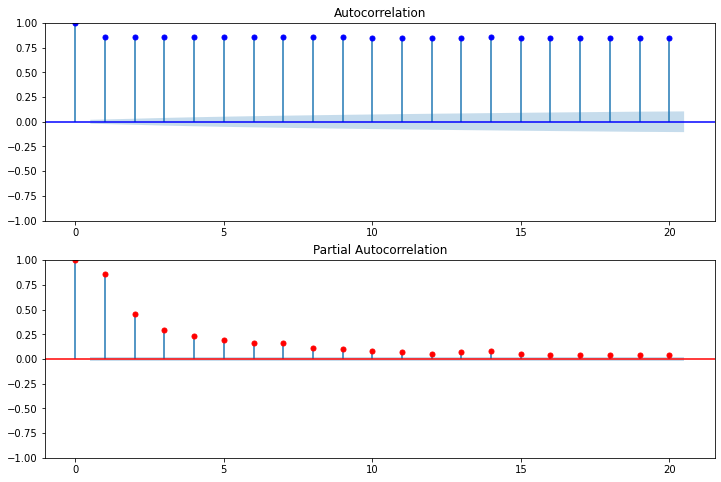

In [ ]:
def adf_test(data_series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ev_data['mean_xco2'], lags=20, ax=axs[0], color='blue')
plot_pacf(ev_data['mean_xco2'], lags=20, ax=axs[1], color='red')
plt.show()

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


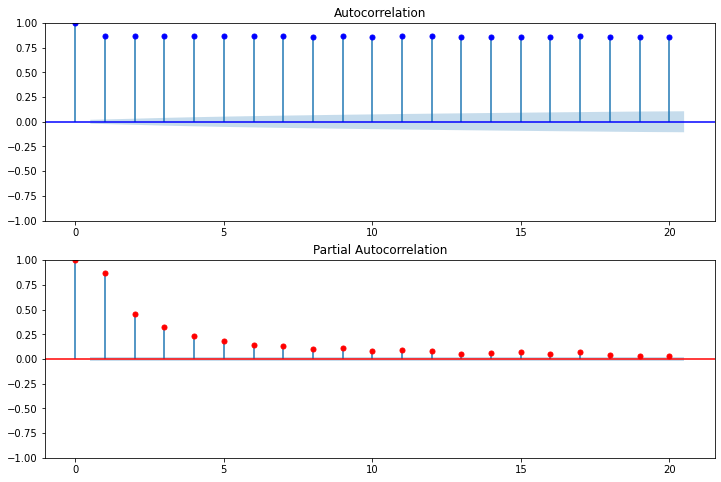

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def adf_test(data_series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(data_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ev_data['mean_xco2'], lags=20, ax=axs[0], color='blue')
plot_pacf(ev_data['mean_xco2'], lags=20, ax=axs[1], color='red')

# Save the plot as 'arimaco.png'
plt.savefig('arimaco.png')

plt.show()


In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from io import BytesIO

# Function to perform the Augmented Dickey-Fuller test
def adf_test(data_series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(data_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Function to save the graph as an image file and return its binary data
def save_plot_to_bytes(figure):
    buffer = BytesIO()
    figure.savefig(buffer, format='png')
    buffer.seek(0)
    return buffer.read()

def store_plots_in_db(filename, data_series):
    # Connect to SQLite database
    conn = sqlite3.connect(filename)
    cursor = conn.cursor()

    # Create a table to store plots if not exists
    cursor.execute('''CREATE TABLE IF NOT EXISTS plots (
                        id INTEGER PRIMARY KEY,
                        plot BLOB
                    )''')

    # Perform ADF test and save the results
    adf_test(data_series)

    # Plot ACF and PACF
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(data_series, lags=20, ax=axs[0], color='blue')
    plot_pacf(data_series, lags=20, ax=axs[1], color='red')
    plt.close()  # Close the plot to prevent displaying it

    # Save the plot as a binary object
    plot_data = save_plot_to_bytes(fig)

    # Insert the plot into the database
    cursor.execute("INSERT INTO plots (plot) VALUES (?)", (sqlite3.Binary(plot_data),))
    conn.commit()

    # Close the cursor and connection
    cursor.close()
    conn.close()

# Example usage
filename = "co2-arima.db"
# Assuming ev_data is your pandas DataFrame containing the 'mean_xco2' column
store_plots_in_db(filename, ev_data['mean_xco2'])


Results of Dickey-Fuller Test:
Test Statistic                   -2.618259
p-value                           0.089282
#Lags Used                       35.000000
Number of Observations Used    9961.000000
Critical Value (1%)              -3.431007
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566924
dtype: float64


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


### ANN (Neural Network)

#### Finance Data

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Model 1 MAE: 0.07450954674124721
Model 2 MAE: 0.1307004597706396
Model 1 RMSE: 0.28571366056799935
Model 2 RMSE: 0.2308763489684052
Model 1 MSE: 0.08163230121135712
Model 2 MSE: 0.05330389365553856


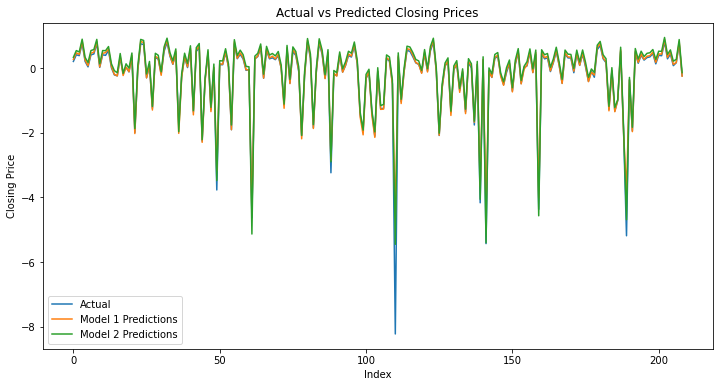

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(f_data[['Open', 'High', 'Low']])
X = scaled_data
y = f_data['Close/Last']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def create_model(num_layers, num_neurons):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
        else:
            model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model1 = create_model(2, 32)
model1.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
model2 = create_model(3, 64)
model2.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)
mse1 = model1.evaluate(X_test, y_test, verbose=0)
mse2 = model2.evaluate(X_test, y_test, verbose=0)
mae1 = mean_absolute_error(y_test, preds1)
mae2 = mean_absolute_error(y_test, preds2)
rmse1 = mean_squared_error(y_test, preds1, squared=False)
rmse2 = mean_squared_error(y_test, preds2, squared=False)
print(f'Model 1 MAE: {mae1}')
print(f'Model 2 MAE: {mae2}')
print(f'Model 1 RMSE: {rmse1}')
print(f'Model 2 RMSE: {rmse2}')
print(f'Model 1 MSE: {mse1}')
print(f'Model 2 MSE: {mse2}')
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(preds1, label='Model 1 Predictions')
plt.plot(preds2, label='Model 2 Predictions')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Index')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\hysam\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\hysam\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Model 1 MAE: 0.06821278859176973
Model 2 MAE: 0.04239101645233444
Model 1 RMSE: 0.26676267975532153
Model 2 RMSE: 0.19401617409134872
Model 1 MSE: 0.07116232812404633
Model 2 MSE: 0.037642285227775574


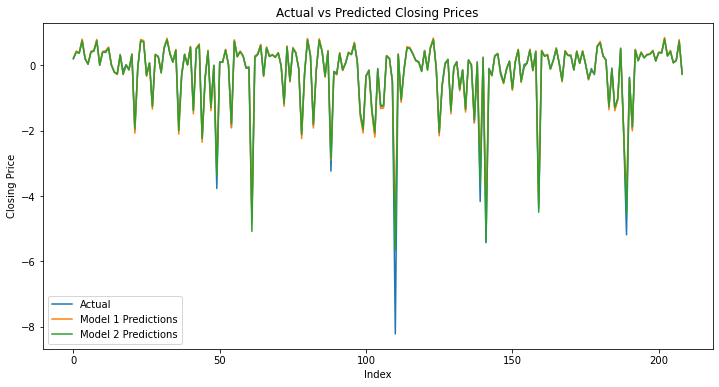

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(f_data[['Open', 'High', 'Low']])
X = scaled_data
y = f_data['Close/Last']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model(num_layers, num_neurons):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
        else:
            model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model1 = create_model(2, 32)
model1.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

model2 = create_model(3, 64)
model2.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)

mse1 = model1.evaluate(X_test, y_test, verbose=0)
mse2 = model2.evaluate(X_test, y_test, verbose=0)

mae1 = mean_absolute_error(y_test, preds1)
mae2 = mean_absolute_error(y_test, preds2)

rmse1 = mean_squared_error(y_test, preds1, squared=False)
rmse2 = mean_squared_error(y_test, preds2, squared=False)

print(f'Model 1 MAE: {mae1}')
print(f'Model 2 MAE: {mae2}')
print(f'Model 1 RMSE: {rmse1}')
print(f'Model 2 RMSE: {rmse2}')
print(f'Model 1 MSE: {mse1}')
print(f'Model 2 MSE: {mse2}')

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(preds1, label='Model 1 Predictions')
plt.plot(preds2, label='Model 2 Predictions')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Index')
plt.ylabel('Closing Price')
plt.legend()

# Save the plot as 'annfin.png'
plt.savefig('annfin.png')

plt.show()


C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Model 1 MAE: 0.05066166334993367
Model 2 MAE: 0.04959643448753774
Model 1 RMSE: 0.22966541908020427
Model 2 RMSE: 0.19719603379037356
Model 1 MSE: 0.05274621769785881
Model 2 MSE: 0.03888627886772156


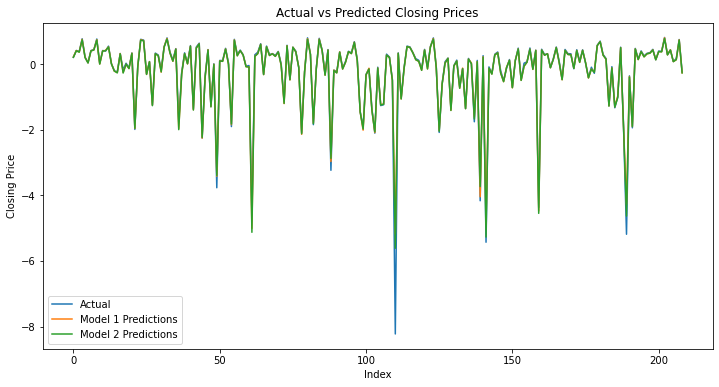

In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# Function to create and compile the neural network model
def create_model(num_layers, num_neurons):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
        else:
            model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Example data preparation and model training
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(f_data[['Open', 'High', 'Low']])
X = scaled_data
y = f_data['Close/Last']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train Model 1
model1 = create_model(2, 32)
model1.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Create and train Model 2
model2 = create_model(3, 64)
model2.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Make predictions
preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)

# Calculate evaluation metrics
mse1 = model1.evaluate(X_test, y_test, verbose=0)
mse2 = model2.evaluate(X_test, y_test, verbose=0)
mae1 = mean_absolute_error(y_test, preds1)
mae2 = mean_absolute_error(y_test, preds2)
rmse1 = mean_squared_error(y_test, preds1, squared=False)
rmse2 = mean_squared_error(y_test, preds2, squared=False)

# Print evaluation metrics
print(f'Model 1 MAE: {mae1}')
print(f'Model 2 MAE: {mae2}')
print(f'Model 1 RMSE: {rmse1}')
print(f'Model 2 RMSE: {rmse2}')
print(f'Model 1 MSE: {mse1}')
print(f'Model 2 MSE: {mse2}')

# Plot actual vs predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(preds1, label='Model 1 Predictions')
plt.plot(preds2, label='Model 2 Predictions')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Index')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Save results to SQLite database
conn = sqlite3.connect("fin-ann.db")
cursor = conn.cursor()

# Create a table to store results if not exists
cursor.execute('''CREATE TABLE IF NOT EXISTS model_results (
                    id INTEGER PRIMARY KEY,
                    model_name TEXT,
                    mae FLOAT,
                    rmse FLOAT,
                    mse FLOAT
                )''')

# Insert Model 1 results into the database
cursor.execute("INSERT INTO model_results (model_name, mae, rmse, mse) VALUES (?, ?, ?, ?)",
               ("Model 1", mae1, rmse1, mse1))

# Insert Model 2 results into the database
cursor.execute("INSERT INTO model_results (model_name, mae, rmse, mse) VALUES (?, ?, ?, ?)",
               ("Model 2", mae2, rmse2, mse2))

# Commit changes and close connection
conn.commit()
conn.close()


#### Energy Data

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model 1 MAE: 0.004456625943581715
Model 2 MAE: 0.007355964511943203
Model 1 RMSE: 0.007547758953298664
Model 2 RMSE: 0.009470160527465885
Model 1 MSE: 5.696866521710014e-05
Model 2 MSE: 8.968394041597292e-05


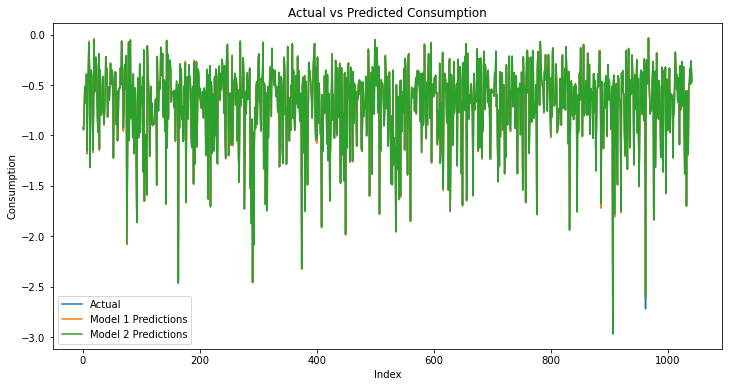

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(e_data[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']])
X = scaled_data
y = e_data['Consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def create_model(num_layers, num_neurons):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
        else:
            model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model1 = create_model(2, 32)
model1.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
model2 = create_model(3, 64)
model2.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)
mse1 = mean_squared_error(y_test, preds1)
mse2 = mean_squared_error(y_test, preds2)
mae1 = mean_absolute_error(y_test, preds1)
mae2 = mean_absolute_error(y_test, preds2)
rmse1 = mean_squared_error(y_test, preds1, squared=False)
rmse2 = mean_squared_error(y_test, preds2, squared=False)
print(f'Model 1 MAE: {mae1}')
print(f'Model 2 MAE: {mae2}')
print(f'Model 1 RMSE: {rmse1}')
print(f'Model 2 RMSE: {rmse2}')
print(f'Model 1 MSE: {mse1}')
print(f'Model 2 MSE: {mse2}')
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(preds1, label='Model 1 Predictions')
plt.plot(preds2, label='Model 2 Predictions')
plt.title('Actual vs Predicted Consumption')
plt.xlabel('Index')
plt.ylabel('Consumption')
plt.legend()
plt.show()

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model 1 MAE: 0.009750105470622559
Model 2 MAE: 0.010387273123514559
Model 1 RMSE: 0.010097727419303848
Model 2 RMSE: 0.012820385573781148
Model 1 MSE: 0.00010196409903456076
Model 2 MSE: 0.00016436228626041577


C:\Users\hysam\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\hysam\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


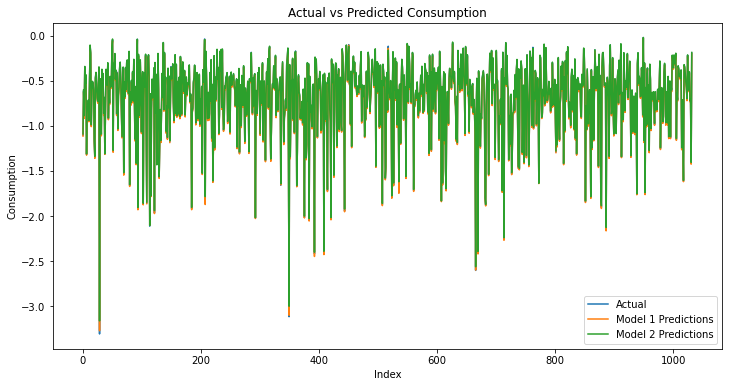

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(e_data[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']])
X = scaled_data
y = e_data['Consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model(num_layers, num_neurons):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
        else:
            model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model1 = create_model(2, 32)
model1.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

model2 = create_model(3, 64)
model2.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)

mse1 = mean_squared_error(y_test, preds1)
mse2 = mean_squared_error(y_test, preds2)

mae1 = mean_absolute_error(y_test, preds1)
mae2 = mean_absolute_error(y_test, preds2)

rmse1 = mean_squared_error(y_test, preds1, squared=False)
rmse2 = mean_squared_error(y_test, preds2, squared=False)

print(f'Model 1 MAE: {mae1}')
print(f'Model 2 MAE: {mae2}')
print(f'Model 1 RMSE: {rmse1}')
print(f'Model 2 RMSE: {rmse2}')
print(f'Model 1 MSE: {mse1}')
print(f'Model 2 MSE: {mse2}')

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(preds1, label='Model 1 Predictions')
plt.plot(preds2, label='Model 2 Predictions')
plt.title('Actual vs Predicted Consumption')
plt.xlabel('Index')
plt.ylabel('Consumption')
plt.legend()

# Save the plot as 'annene.png'
plt.savefig('annene.png')

plt.show()


C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model 1 MAE: 0.007276547501934973
Model 2 MAE: 0.004716112474090168
Model 1 RMSE: 0.010274948261242303
Model 2 RMSE: 0.006413017745604631
Model 1 MSE: 0.00010557456177120622
Model 2 MSE: 4.112679660543991e-05


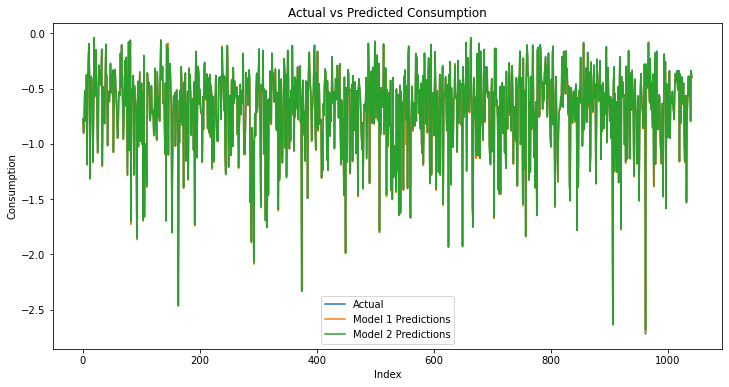

In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# Function to create and compile the neural network model
def create_model(num_layers, num_neurons):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
        else:
            model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Example data preparation and model training
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(e_data[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']])
X = scaled_data
y = e_data['Consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train Model 1
model1 = create_model(2, 32)
model1.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Create and train Model 2
model2 = create_model(3, 64)
model2.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Make predictions
preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)

# Calculate evaluation metrics
mse1 = mean_squared_error(y_test, preds1)
mse2 = mean_squared_error(y_test, preds2)
mae1 = mean_absolute_error(y_test, preds1)
mae2 = mean_absolute_error(y_test, preds2)
rmse1 = mean_squared_error(y_test, preds1, squared=False)
rmse2 = mean_squared_error(y_test, preds2, squared=False)

# Print evaluation metrics
print(f'Model 1 MAE: {mae1}')
print(f'Model 2 MAE: {mae2}')
print(f'Model 1 RMSE: {rmse1}')
print(f'Model 2 RMSE: {rmse2}')
print(f'Model 1 MSE: {mse1}')
print(f'Model 2 MSE: {mse2}')

# Plot actual vs predicted consumption
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(preds1, label='Model 1 Predictions')
plt.plot(preds2, label='Model 2 Predictions')
plt.title('Actual vs Predicted Consumption')
plt.xlabel('Index')
plt.ylabel('Consumption')
plt.legend()
plt.show()

# Save results to SQLite database
conn = sqlite3.connect("energy-ann.db")
cursor = conn.cursor()

# Create a table to store results if not exists
cursor.execute('''CREATE TABLE IF NOT EXISTS model_results (
                    id INTEGER PRIMARY KEY,
                    model_name TEXT,
                    mae FLOAT,
                    rmse FLOAT,
                    mse FLOAT
                )''')

# Insert Model 1 results into the database
cursor.execute("INSERT INTO model_results (model_name, mae, rmse, mse) VALUES (?, ?, ?, ?)",
               ("Model 1", mae1, rmse1, mse1))

# Insert Model 2 results into the database
cursor.execute("INSERT INTO model_results (model_name, mae, rmse, mse) VALUES (?, ?, ?, ?)",
               ("Model 2", mae2, rmse2, mse2))

# Commit changes and close connection
conn.commit()
conn.close()


#### Co2 Data

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model 1 MAE: 0.12068680642343214
Model 2 MAE: 0.12237429126043364
Model 1 RMSE: 0.1490256770184102
Model 2 RMSE: 0.1493573256079361
Model 1 MSE: 0.022208653390407562
Model 2 MSE: 0.022307608276605606


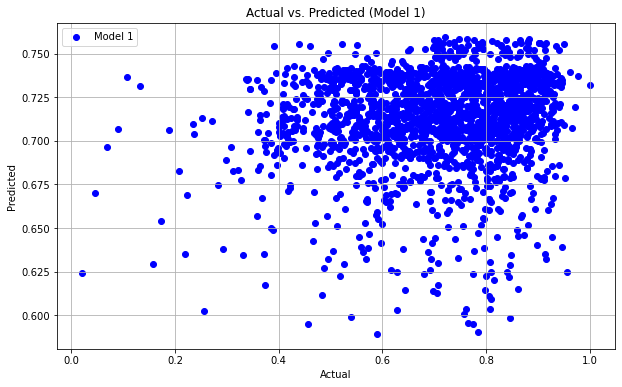

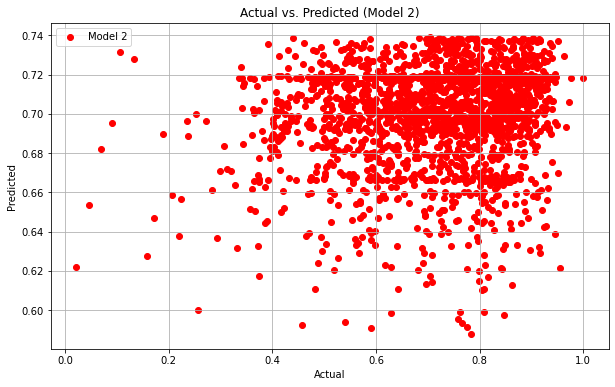

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ev_data[['x', 'y', 'mean_xco2']])
X = scaled_data[:, :-1]
y = scaled_data[:, -1].reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def create_model(num_layers, num_neurons):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
        else:
            model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model1 = create_model(2, 32)
model1.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
model2 = create_model(3, 64)
model2.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)
mse1 = model1.evaluate(X_test, y_test, verbose=0)
mse2 = model2.evaluate(X_test, y_test, verbose=0)
mae1 = mean_absolute_error(y_test, preds1)
mae2 = mean_absolute_error(y_test, preds2)
rmse1 = mean_squared_error(y_test, preds1, squared=False)
rmse2 = mean_squared_error(y_test, preds2, squared=False)
print(f'Model 1 MAE: {mae1}')
print(f'Model 2 MAE: {mae2}')
print(f'Model 1 RMSE: {rmse1}')
print(f'Model 2 RMSE: {rmse2}')
print(f'Model 1 MSE: {mse1}')
print(f'Model 2 MSE: {mse2}')
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds1, color='blue', label='Model 1')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (Model 1)')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds2, color='red', label='Model 2')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (Model 2)')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model 1 MAE: 0.14718007403345887
Model 2 MAE: 0.14610611180639588
Model 1 RMSE: 0.17606752364606357
Model 2 RMSE: 0.17583929855751299
Model 1 MSE: 0.030999772882857154
Model 2 MSE: 0.030919458917198186


C:\Users\hysam\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\hysam\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


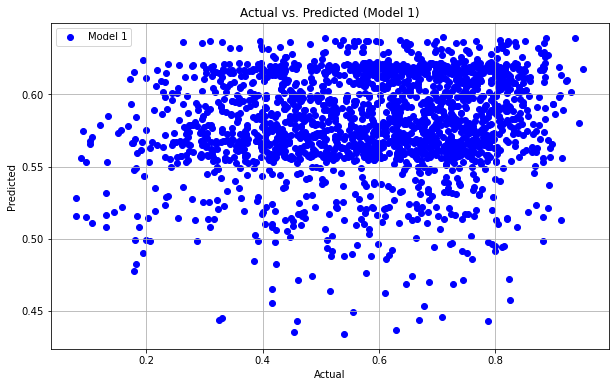

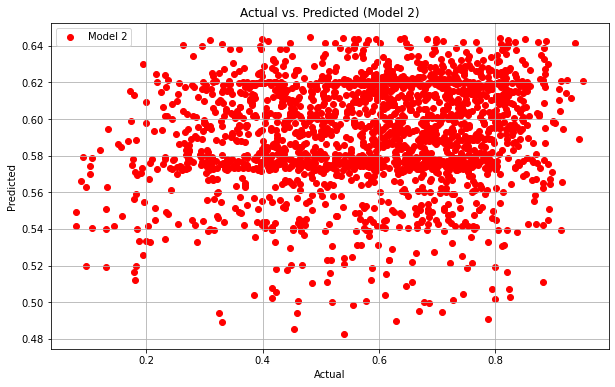

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ev_data[['x', 'y', 'mean_xco2']])
X = scaled_data[:, :-1]
y = scaled_data[:, -1].reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model(num_layers, num_neurons):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
        else:
            model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model1 = create_model(2, 32)
model1.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

model2 = create_model(3, 64)
model2.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)

mse1 = mean_squared_error(y_test, preds1)
mse2 = mean_squared_error(y_test, preds2)

mae1 = mean_absolute_error(y_test, preds1)
mae2 = mean_absolute_error(y_test, preds2)

rmse1 = mean_squared_error(y_test, preds1, squared=False)
rmse2 = mean_squared_error(y_test, preds2, squared=False)

print(f'Model 1 MAE: {mae1}')
print(f'Model 2 MAE: {mae2}')
print(f'Model 1 RMSE: {rmse1}')
print(f'Model 2 RMSE: {rmse2}')
print(f'Model 1 MSE: {mse1}')
print(f'Model 2 MSE: {mse2}')

plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds1, color='blue', label='Model 1')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (Model 1)')
plt.legend()
plt.grid(True)

# Save the plot as 'annene.png'
plt.savefig('annene.png')

plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds2, color='red', label='Model 2')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (Model 2)')
plt.legend()
plt.grid(True)

# Save the plot as 'annene.png'
plt.savefig('annco.png')

plt.show()


C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model 1 MAE: 0.12065524128651624
Model 2 MAE: 0.11971341543130355
Model 1 RMSE: 0.14995333457786028
Model 2 RMSE: 0.15010923135930462
Model 1 MSE: 0.02248600255101971
Model 2 MSE: 0.022532781339281244


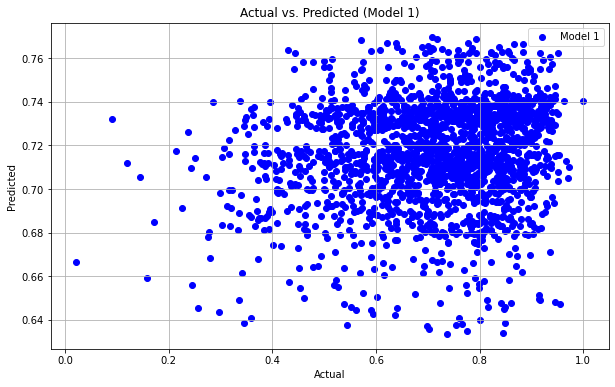

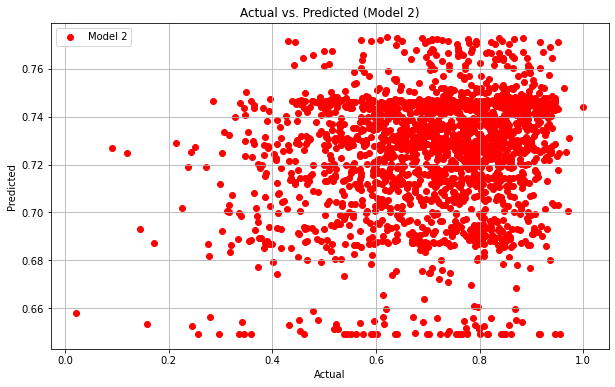

In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# Function to create and compile the neural network model
def create_model(num_layers, num_neurons):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
        else:
            model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Example data preparation and model training
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ev_data[['x', 'y', 'mean_xco2']])
X = scaled_data[:, :-1]
y = scaled_data[:, -1].reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train Model 1
model1 = create_model(2, 32)
model1.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Create and train Model 2
model2 = create_model(3, 64)
model2.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Make predictions
preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)

# Calculate evaluation metrics
mse1 = mean_squared_error(y_test, preds1)
mse2 = mean_squared_error(y_test, preds2)
mae1 = mean_absolute_error(y_test, preds1)
mae2 = mean_absolute_error(y_test, preds2)
rmse1 = mean_squared_error(y_test, preds1, squared=False)
rmse2 = mean_squared_error(y_test, preds2, squared=False)

# Print evaluation metrics
print(f'Model 1 MAE: {mae1}')
print(f'Model 2 MAE: {mae2}')
print(f'Model 1 RMSE: {rmse1}')
print(f'Model 2 RMSE: {rmse2}')
print(f'Model 1 MSE: {mse1}')
print(f'Model 2 MSE: {mse2}')

# Plot actual vs predicted for Model 1
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds1, color='blue', label='Model 1')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (Model 1)')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted for Model 2
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds2, color='red', label='Model 2')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (Model 2)')
plt.legend()
plt.grid(True)
plt.show()

# Save results to SQLite database
conn = sqlite3.connect("co2_ann.db")
cursor = conn.cursor()

# Create a table to store results if not exists
cursor.execute('''CREATE TABLE IF NOT EXISTS model_results (
                    id INTEGER PRIMARY KEY,
                    model_name TEXT,
                    mae FLOAT,
                    rmse FLOAT,
                    mse FLOAT
                )''')

# Insert Model 1 results into the database
cursor.execute("INSERT INTO model_results (model_name, mae, rmse, mse) VALUES (?, ?, ?, ?)",
               ("Model 1", mae1, rmse1, mse1))

# Insert Model 2 results into the database
cursor.execute("INSERT INTO model_results (model_name, mae, rmse, mse) VALUES (?, ?, ?, ?)",
               ("Model 2", mae2, rmse2, mse2))

# Commit changes and close connection
conn.commit()
conn.close()


### SARIMA (Seasonal ARIMA)

#### Finanace Data

Results of Dickey-Fuller Test:
Test Statistic                   -3.149069
p-value                           0.023129
#Lags Used                       16.000000
Number of Observations Used    1025.000000
Critical Value (1%)              -3.436746
Critical Value (5%)              -2.864364
Critical Value (10%)             -2.568274
dtype: float64

ADF Test Results after seasonal differencing:
Test Statistic: -7.514538675241218
p-value: 3.9349075681278335e-11
Critical Values: {'1%': -3.436860474327014, '5%': -2.8644144230916537, '10%': -2.568300476140699}


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC: 226.1009937943465
BIC: 250.72896977989882


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hysam\AppData\Local\Temp\ipykernel_3740\3397703441.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


MAPE: nan


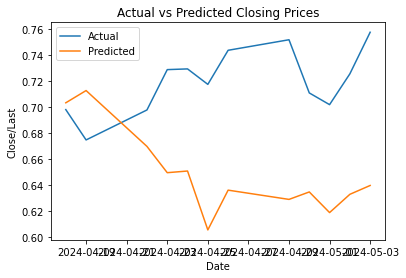

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
adf_test(f_data['Close/Last'])
seasonal_diff = f_data['Close/Last'].diff(12)  
seasonal_diff = seasonal_diff.dropna()
adf_seasonal_diff = adfuller(seasonal_diff)
print('\nADF Test Results after seasonal differencing:')
print('Test Statistic:', adf_seasonal_diff[0])
print('p-value:', adf_seasonal_diff[1])
print('Critical Values:', adf_seasonal_diff[4])
train_data = f_data.iloc[:-12]  # Exclude the last 12 months for testing
test_data = f_data.iloc[-12:]
p = 1
d = 0
q = 1
P = 1
D = 1
Q = 1
model = SARIMAX(train_data['Close/Last'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()
print('AIC:', results.aic)
print('BIC:', results.bic)
y_pred = results.predict(start=len(train_data), end=len(train_data)+11, dynamic=True)
mape = mean_absolute_percentage_error(test_data['Close/Last'], y_pred)
print('MAPE:', mape)
plt.plot(test_data.index, test_data['Close/Last'], label='Actual')
plt.plot(test_data.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close/Last')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   -3.149069
p-value                           0.023129
#Lags Used                       16.000000
Number of Observations Used    1025.000000
Critical Value (1%)              -3.436746
Critical Value (5%)              -2.864364
Critical Value (10%)             -2.568274
dtype: float64

ADF Test Results after seasonal differencing:
Test Statistic: -7.514538675241218
p-value: 3.9349075681278335e-11
Critical Values: {'1%': -3.436860474327014, '5%': -2.8644144230916537, '10%': -2.568300476140699}


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC: 226.1009937943465
BIC: 250.72896977989882


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hysam\AppData\Local\Temp\ipykernel_10704\2863565453.py:8: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


MAPE: nan


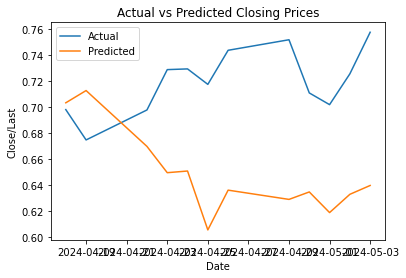

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

adf_test(f_data['Close/Last'])

seasonal_diff = f_data['Close/Last'].diff(12)
seasonal_diff = seasonal_diff.dropna()
adf_seasonal_diff = adfuller(seasonal_diff)
print('\nADF Test Results after seasonal differencing:')
print('Test Statistic:', adf_seasonal_diff[0])
print('p-value:', adf_seasonal_diff[1])
print('Critical Values:', adf_seasonal_diff[4])

train_data = f_data.iloc[:-12]  # Exclude the last 12 months for testing
test_data = f_data.iloc[-12:]

p = 1
d = 0
q = 1
P = 1
D = 1
Q = 1

model = SARIMAX(train_data['Close/Last'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()
print('AIC:', results.aic)
print('BIC:', results.bic)

y_pred = results.predict(start=len(train_data), end=len(train_data) + 11, dynamic=True)

mape = mean_absolute_percentage_error(test_data['Close/Last'], y_pred)
print('MAPE:', mape)

plt.plot(test_data.index, test_data['Close/Last'], label='Actual')
plt.plot(test_data.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close/Last')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()

# Save the plot as 'sarimafin.png'
plt.savefig('sarimafin.png')

plt.show()


Results of Dickey-Fuller Test:
Test Statistic                   -3.149069
p-value                           0.023129
#Lags Used                       16.000000
Number of Observations Used    1025.000000
Critical Value (1%)              -3.436746
Critical Value (5%)              -2.864364
Critical Value (10%)             -2.568274
dtype: float64

ADF Test Results after seasonal differencing:
Test Statistic: -7.514538675241218
p-value: 3.9349075681278335e-11
Critical Values: {'1%': -3.436860474327014, '5%': -2.8644144230916537, '10%': -2.568300476140699}


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC: 226.1009937943465
BIC: 250.72896977989882
MAPE: nan


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hysam\AppData\Local\Temp\ipykernel_3740\839923876.py:10: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


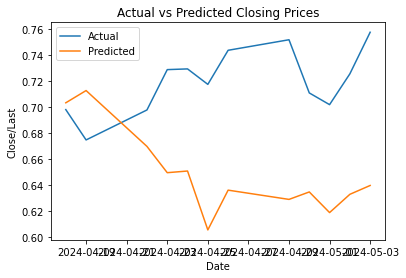

In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Function to calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to perform the Augmented Dickey-Fuller test
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Perform ADF test on original data
adf_test(f_data['Close/Last'])

# Perform seasonal differencing
seasonal_diff = f_data['Close/Last'].diff(12).dropna()
adf_seasonal_diff = adfuller(seasonal_diff)
print('\nADF Test Results after seasonal differencing:')
print('Test Statistic:', adf_seasonal_diff[0])
print('p-value:', adf_seasonal_diff[1])
print('Critical Values:', adf_seasonal_diff[4])

# Train SARIMA model
train_data = f_data.iloc[:-12]  # Exclude the last 12 months for testing
test_data = f_data.iloc[-12:]
p = 1
d = 0
q = 1
P = 1
D = 1
Q = 1
model = SARIMAX(train_data['Close/Last'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()
print('AIC:', results.aic)
print('BIC:', results.bic)

# Generate predictions
y_pred = results.predict(start=len(train_data), end=len(train_data)+11, dynamic=True)
mape = mean_absolute_percentage_error(test_data['Close/Last'], y_pred)
print('MAPE:', mape)

# Plot actual vs predicted closing prices
plt.plot(test_data.index, test_data['Close/Last'], label='Actual')
plt.plot(test_data.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close/Last')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

# Save results to SQLite database
conn = sqlite3.connect("sarima_fin.db")
cursor = conn.cursor()

# Create a table to store results if not exists
cursor.execute('''CREATE TABLE IF NOT EXISTS sarima_results (
                    id INTEGER PRIMARY KEY,
                    model_name TEXT,
                    AIC FLOAT,
                    BIC FLOAT,
                    MAPE FLOAT
                )''')

# Insert SARIMA model results into the database
cursor.execute("INSERT INTO sarima_results (model_name, AIC, BIC, MAPE) VALUES (?, ?, ?, ?)",
               ("SARIMA", results.aic, results.bic, mape))

# Commit changes and close connection
conn.commit()
conn.close()


#### Energy Data

Results of Dickey-Fuller Test:
Test Statistic                -5.844743e+00
p-value                        3.706186e-07
#Lags Used                     2.300000e+01
Number of Observations Used    5.183000e+03
Critical Value (1%)           -3.431612e+00
Critical Value (5%)           -2.862098e+00
Critical Value (10%)          -2.567067e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.484755
p-value                           0.000000
#Lags Used                       27.000000
Number of Observations Used    5178.000000
Critical Value (1%)              -3.431614
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC: 76.34194052184654
BIC: 109.12977594961909
MAPE: nan


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hysam\AppData\Local\Temp\ipykernel_3740\3397703441.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


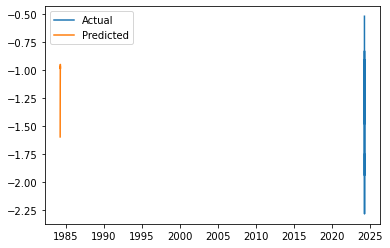

In [ ]:
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

adf_test(e_data['Consumption'])
e_data['diff_Consumption'] = e_data['Consumption'] - e_data['Consumption'].shift(1)
e_data = e_data.dropna()
adf_test(e_data['diff_Consumption'])
p = 1
d = 0
q = 1
P = 1
D = 0
Q = 1

model = SARIMAX(e_data['Consumption'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()

print('AIC:', results.aic)
print('BIC:', results.bic)
y_pred = results.predict(start=len(e_data), end=len(e_data)+11, dynamic=True)
mape = mean_absolute_percentage_error(e_data['Consumption'].iloc[-12:], y_pred)
print('MAPE:', mape)
plt.plot(e_data['Consumption'].iloc[-12:], label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   -5.621243
p-value                           0.000001
#Lags Used                       23.000000
Number of Observations Used    5135.000000
Critical Value (1%)              -3.431624
Critical Value (5%)              -2.862103
Critical Value (10%)             -2.567070
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -25.908170
p-value                           0.000000
#Lags Used                       22.000000
Number of Observations Used    5135.000000
Critical Value (1%)              -3.431624
Critical Value (5%)              -2.862103
Critical Value (10%)             -2.567070
dtype: float64


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC: 405.70109016465733
BIC: 438.4426110968638
MAPE: nan


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hysam\AppData\Local\Temp\ipykernel_10704\2863565453.py:8: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


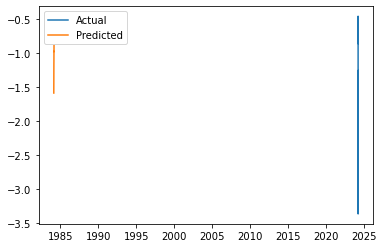

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

adf_test(e_data['Consumption'])

e_data['diff_Consumption'] = e_data['Consumption'] - e_data['Consumption'].shift(1)
e_data = e_data.dropna()
adf_test(e_data['diff_Consumption'])

p = 1
d = 0
q = 1
P = 1
D = 0
Q = 1

model = SARIMAX(e_data['Consumption'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()

print('AIC:', results.aic)
print('BIC:', results.bic)

y_pred = results.predict(start=len(e_data), end=len(e_data)+11, dynamic=True)
mape = mean_absolute_percentage_error(e_data['Consumption'].iloc[-12:], y_pred)
print('MAPE:', mape)

plt.plot(e_data['Consumption'].iloc[-12:], label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()

# Save the plot as 'sarimaene.png'
plt.savefig('sarimaene.png')

plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -5.856287e+00
p-value                        3.493888e-07
#Lags Used                     2.300000e+01
Number of Observations Used    5.182000e+03
Critical Value (1%)           -3.431613e+00
Critical Value (5%)           -2.862098e+00
Critical Value (10%)          -2.567067e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.475696
p-value                           0.000000
#Lags Used                       27.000000
Number of Observations Used    5177.000000
Critical Value (1%)              -3.431614
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC: 77.1417193205599
BIC: 109.92859422580524
MAPE: nan


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hysam\AppData\Local\Temp\ipykernel_3740\839923876.py:10: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


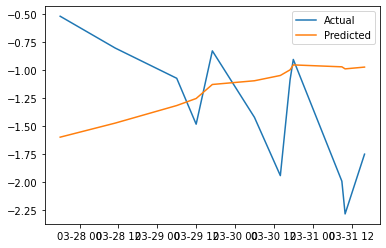

In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Function to perform the Augmented Dickey-Fuller test
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Perform ADF test on original consumption data
adf_test(e_data['Consumption'])

# Perform differencing and ADF test
e_data['diff_Consumption'] = e_data['Consumption'] - e_data['Consumption'].shift(1)
e_data = e_data.dropna()
adf_test(e_data['diff_Consumption'])

# Define SARIMA parameters
p = 1
d = 0
q = 1
P = 1
D = 0
Q = 1

# Fit SARIMA model
model = SARIMAX(e_data['Consumption'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()

# Calculate AIC, BIC, and MAPE
print('AIC:', results.aic)
print('BIC:', results.bic)
y_pred = results.predict(start=len(e_data), end=len(e_data)+11, dynamic=True)
mape = mean_absolute_percentage_error(e_data['Consumption'].iloc[-12:], y_pred)
print('MAPE:', mape)

# Plot actual vs predicted consumption
plt.plot(e_data.index[-12:], e_data['Consumption'].iloc[-12:], label='Actual')
plt.plot(e_data.index[-12:], y_pred, label='Predicted')
plt.legend()
plt.show()

# Save results to SQLite database
conn = sqlite3.connect("sarima_energy.db")
cursor = conn.cursor()

# Create a table to store results if not exists
cursor.execute('''CREATE TABLE IF NOT EXISTS sarima_results (
                    id INTEGER PRIMARY KEY,
                    model_name TEXT,
                    AIC FLOAT,
                    BIC FLOAT,
                    MAPE FLOAT
                )''')

# Insert SARIMA model results into the database
cursor.execute("INSERT INTO sarima_results (model_name, AIC, BIC, MAPE) VALUES (?, ?, ?, ?)",
               ("SARIMA", results.aic, results.bic, mape))

# Commit changes and close connection
conn.commit()
conn.close()


#### Co2 Data

Results of Dickey-Fuller Test:
Test Statistic                   -2.728606
p-value                           0.069218
#Lags Used                       35.000000
Number of Observations Used    9962.000000
Critical Value (1%)              -3.431007
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566924
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -24.988831
p-value                           0.000000
#Lags Used                       38.000000
Number of Observations Used    9958.000000
Critical Value (1%)              -3.431007
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566925
dtype: float64


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC: -13152.05503452679
BIC: -13116.011339073742


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


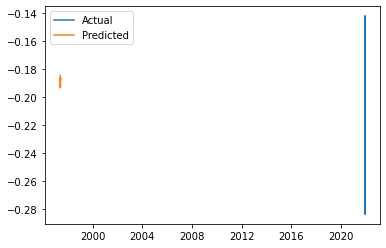

In [ ]:
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
adf_test(ev_data['mean_xco2'])

ev_data['diff_mean_xco2'] = ev_data['mean_xco2'] - ev_data['mean_xco2'].shift(1)
ev_data = ev_data.dropna()
adf_test(ev_data['diff_mean_xco2'])
p = 1
d = 1
q = 1
P = 1
D = 1
Q = 1

model = SARIMAX(ev_data['mean_xco2'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()
print('AIC:', results.aic)
print('BIC:', results.bic)
y_pred = results.predict(start=len(ev_data), end=len(ev_data)+11, dynamic=True)
plt.plot(ev_data['mean_xco2'].iloc[-12:], label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   -1.783314
p-value                           0.388777
#Lags Used                       37.000000
Number of Observations Used    9961.000000
Critical Value (1%)              -3.431007
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566924
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -27.132896
p-value                           0.000000
#Lags Used                       38.000000
Number of Observations Used    9959.000000
Critical Value (1%)              -3.431007
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566925
dtype: float64


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC: -30826.303674445226
BIC: -30790.259478215976


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


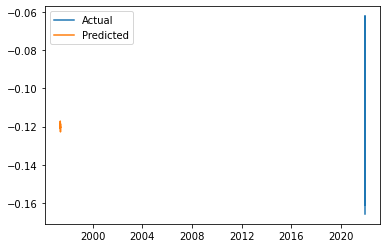

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

adf_test(ev_data['mean_xco2'])

ev_data['diff_mean_xco2'] = ev_data['mean_xco2'] - ev_data['mean_xco2'].shift(1)
ev_data = ev_data.dropna()
adf_test(ev_data['diff_mean_xco2'])

p = 1
d = 1
q = 1
P = 1
D = 1
Q = 1

model = SARIMAX(ev_data['mean_xco2'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()
print('AIC:', results.aic)
print('BIC:', results.bic)

y_pred = results.predict(start=len(ev_data), end=len(ev_data)+11, dynamic=True)

plt.plot(ev_data['mean_xco2'].iloc[-12:], label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()

# Save the plot as 'sarimaco2.png'
plt.savefig('sarimaco.png')

plt.show()


Results of Dickey-Fuller Test:
Test Statistic                   -2.618259
p-value                           0.089282
#Lags Used                       35.000000
Number of Observations Used    9961.000000
Critical Value (1%)              -3.431007
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566924
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -25.003324
p-value                           0.000000
#Lags Used                       38.000000
Number of Observations Used    9957.000000
Critical Value (1%)              -3.431007
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566925
dtype: float64


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC: -13149.7302896539
BIC: -13113.687095027219


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


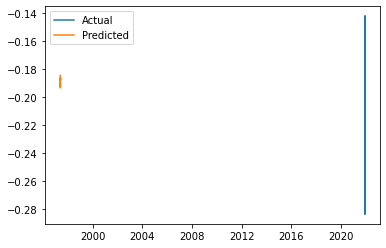

In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Function to perform the Augmented Dickey-Fuller test
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Perform ADF test on original data
adf_test(ev_data['mean_xco2'])

# Perform differencing and ADF test
ev_data['diff_mean_xco2'] = ev_data['mean_xco2'] - ev_data['mean_xco2'].shift(1)
ev_data = ev_data.dropna()
adf_test(ev_data['diff_mean_xco2'])

# Define SARIMA parameters
p = 1
d = 1
q = 1
P = 1
D = 1
Q = 1

# Fit SARIMA model
model = SARIMAX(ev_data['mean_xco2'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()

# Calculate AIC and BIC
print('AIC:', results.aic)
print('BIC:', results.bic)

# Generate predictions
y_pred = results.predict(start=len(ev_data), end=len(ev_data)+11, dynamic=True)

# Plot actual vs predicted values
plt.plot(ev_data['mean_xco2'].iloc[-12:], label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# Save results to SQLite database
conn = sqlite3.connect("sarima_co2.db")
cursor = conn.cursor()

# Create a table to store results if not exists
cursor.execute('''CREATE TABLE IF NOT EXISTS sarima_results (
                    id INTEGER PRIMARY KEY,
                    model_name TEXT,
                    AIC FLOAT,
                    BIC FLOAT
                )''')

# Insert SARIMA model results into the database
cursor.execute("INSERT INTO sarima_results (model_name, AIC, BIC) VALUES (?, ?, ?)",
               ("SARIMA", results.aic, results.bic))

# Commit changes and close connection
conn.commit()
conn.close()


### Exponential Smoothing (ETS):

#### Finance Data

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

Simple Exponential Smoothing (SES) Forecast:
1042    0.744136
1043    0.744136
1044    0.744136
1045    0.744136
1046    0.744136
1047    0.744136
1048    0.744136
1049    0.744136
1050    0.744136
1051    0.744136
1052    0.744136
1053    0.744136
1054    0.744136
1055    0.744136
1056    0.744136
1057    0.744136
1058    0.744136
1059    0.744136
1060    0.744136
1061    0.744136
1062    0.744136
1063    0.744136
1064    0.744136
1065    0.744136
1066    0.744136
1067    0.744136
1068    0.744136
1069    0.744136
1070    0.744136
1071    0.744136
1072    0.744136
1073    0.744136
dtype: float64

Holt's Linear Trend (HLT) Forecast:
1042    0.751851
1043    0.756824
1044    0.761796
1045    0.766768
1046    0.771741
1047    0.776713
1048    0.781685
1049    0.786658
1050    0.791630
1051    0.796602
1052    0.801575
1053    0.806547
1054    0.811519
1055    0.816492
1056    0.821464
1057    0.826436
1058    0.831409
1059    0.836381
1060    0.841354
1061    0.846326
1062    0.851298
10

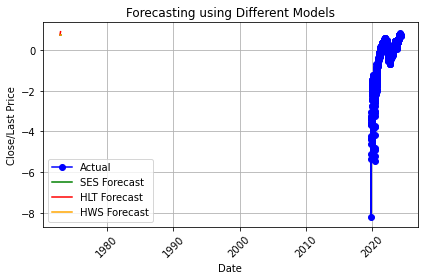

In [ ]:
close_last = f_data['Close/Last']
ses_model = SimpleExpSmoothing(close_last)
ses_fit = ses_model.fit()
hlt_model = Holt(close_last)
hlt_fit = hlt_model.fit()
hws_model =ExponentialSmoothing(close_last, seasonal_periods=12)
hws_fit = hws_model.fit()
ses_forecast = ses_fit.forecast(steps=32)
hlt_forecast = hlt_fit.forecast(steps=32)
hws_forecast = hws_fit.forecast(steps=32)
print("Simple Exponential Smoothing (SES) Forecast:")
print(ses_forecast)
print("\nHolt's Linear Trend (HLT) Forecast:")
print(hlt_forecast)
print("\nHolt-Winters' Seasonal (HWS) Forecast:")
print(hws_forecast)
plt.plot(close_last.index, close_last, label='Actual', marker='o', color='blue')
plt.plot(ses_forecast.index, ses_forecast, label='SES Forecast', color='green')
plt.plot(hlt_forecast.index, hlt_forecast, label="HLT Forecast", color='red')
plt.plot(hws_forecast.index, hws_forecast, label="HWS Forecast", color='orange')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.title('Forecasting using Different Models')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

Simple Exponential Smoothing (SES) Forecast:
1042    0.744136
1043    0.744136
1044    0.744136
1045    0.744136
1046    0.744136
1047    0.744136
1048    0.744136
1049    0.744136
1050    0.744136
1051    0.744136
1052    0.744136
1053    0.744136
1054    0.744136
1055    0.744136
1056    0.744136
1057    0.744136
1058    0.744136
1059    0.744136
1060    0.744136
1061    0.744136
1062    0.744136
1063    0.744136
1064    0.744136
1065    0.744136
1066    0.744136
1067    0.744136
1068    0.744136
1069    0.744136
1070    0.744136
1071    0.744136
1072    0.744136
1073    0.744136
dtype: float64

Holt's Linear Trend (HLT) Forecast:
1042    0.751851
1043    0.756824
1044    0.761796
1045    0.766768
1046    0.771741
1047    0.776713
1048    0.781685
1049    0.786658
1050    0.791630
1051    0.796602
1052    0.801575
1053    0.806547
1054    0.811519
1055    0.816492
1056    0.821464
1057    0.826436
1058    0.831409
1059    0.836381
1060    0.841354
1061    0.846326
1062    0.851298
10

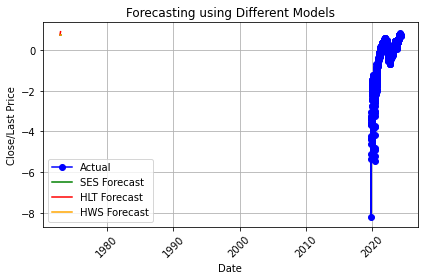

In [22]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

close_last = f_data['Close/Last']
ses_model = SimpleExpSmoothing(close_last)
ses_fit = ses_model.fit()
hlt_model = Holt(close_last)
hlt_fit = hlt_model.fit()
hws_model = ExponentialSmoothing(close_last, seasonal_periods=12)
hws_fit = hws_model.fit()

ses_forecast = ses_fit.forecast(steps=32)
hlt_forecast = hlt_fit.forecast(steps=32)
hws_forecast = hws_fit.forecast(steps=32)

print("Simple Exponential Smoothing (SES) Forecast:")
print(ses_forecast)
print("\nHolt's Linear Trend (HLT) Forecast:")
print(hlt_forecast)
print("\nHolt-Winters' Seasonal (HWS) Forecast:")
print(hws_forecast)

plt.plot(close_last.index, close_last, label='Actual', marker='o', color='blue')
plt.plot(ses_forecast.index, ses_forecast, label='SES Forecast', color='green')
plt.plot(hlt_forecast.index, hlt_forecast, label="HLT Forecast", color='red')
plt.plot(hws_forecast.index, hws_forecast, label="HWS Forecast", color='orange')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.title('Forecasting using Different Models')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save the plot as 'etsfin.png'
plt.savefig('etsfin.png')

plt.show()


#### Energy Data

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

Simple Exponential Smoothing (SES) Forecast:
35   -0.83805
36   -0.83805
37   -0.83805
38   -0.83805
39   -0.83805
40   -0.83805
41   -0.83805
42   -0.83805
43   -0.83805
44   -0.83805
45   -0.83805
46   -0.83805
47   -0.83805
48   -0.83805
49   -0.83805
50   -0.83805
51   -0.83805
52   -0.83805
53   -0.83805
54   -0.83805
55   -0.83805
56   -0.83805
57   -0.83805
58   -0.83805
59   -0.83805
60   -0.83805
61   -0.83805
62   -0.83805
63   -0.83805
64   -0.83805
65   -0.83805
66   -0.83805
dtype: float64

Holt's Linear Trend (HLT) Forecast:
35   -0.855942
36   -0.869587
37   -0.883233
38   -0.896878
39   -0.910524
40   -0.924169
41   -0.937815
42   -0.951461
43   -0.965106
44   -0.978752
45   -0.992397
46   -1.006043
47   -1.019688
48   -1.033334
49   -1.046979
50   -1.060625
51   -1.074270
52   -1.087916
53   -1.101562
54   -1.115207
55   -1.128853
56   -1.142498
57   -1.156144
58   -1.169789
59   -1.183435
60   -1.197080
61   -1.210726
62   -1.224371
63   -1.238017
64   -1.251663
65   

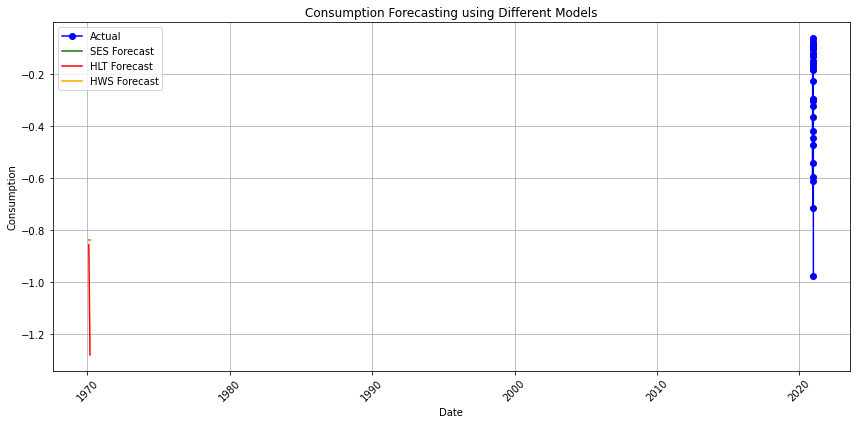

In [ ]:
consumption = e_data['Consumption']
consumption = consumption[1990:2025]
ses_model = SimpleExpSmoothing(consumption)
ses_fit = ses_model.fit()
hlt_model = Holt(consumption)
hlt_fit = hlt_model.fit()
hws_model = ExponentialSmoothing(consumption, seasonal_periods=24)
hws_fit = hws_model.fit()
ses_forecast = ses_fit.forecast(steps=32)
hlt_forecast = hlt_fit.forecast(steps=32)
hws_forecast = hws_fit.forecast(steps=32)
print("Simple Exponential Smoothing (SES) Forecast:")
print(ses_forecast)
print("\nHolt's Linear Trend (HLT) Forecast:")
print(hlt_forecast)
print("\nHolt-Winters' Seasonal (HWS) Forecast:")
print(hws_forecast)
plt.figure(figsize=(12, 6))
plt.plot(consumption.index, consumption, label='Actual', marker='o', color='blue')
plt.plot(ses_forecast.index, ses_forecast, label='SES Forecast', color='green')
plt.plot(hlt_forecast.index, hlt_forecast, label="HLT Forecast", color='red')
plt.plot(hws_forecast.index, hws_forecast, label="HWS Forecast", color='orange')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Consumption Forecasting using Different Models')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

Simple Exponential Smoothing (SES) Forecast:
35   -0.124146
36   -0.124146
37   -0.124146
38   -0.124146
39   -0.124146
40   -0.124146
41   -0.124146
42   -0.124146
43   -0.124146
44   -0.124146
45   -0.124146
46   -0.124146
47   -0.124146
48   -0.124146
49   -0.124146
50   -0.124146
51   -0.124146
52   -0.124146
53   -0.124146
54   -0.124146
55   -0.124146
56   -0.124146
57   -0.124146
58   -0.124146
59   -0.124146
60   -0.124146
61   -0.124146
62   -0.124146
63   -0.124146
64   -0.124146
65   -0.124146
66   -0.124146
dtype: float64

Holt's Linear Trend (HLT) Forecast:
35   -0.126264
36   -0.127724
37   -0.129184
38   -0.130644
39   -0.132103
40   -0.133563
41   -0.135023
42   -0.136482
43   -0.137942
44   -0.139402
45   -0.140861
46   -0.142321
47   -0.143781
48   -0.145240
49   -0.146700
50   -0.148160
51   -0.149620
52   -0.151079
53   -0.152539
54   -0.153999
55   -0.155458
56   -0.156918
57   -0.158378
58   -0.159837
59   -0.161297
60   -0.162757
61   -0.164217
62   -0.165676
63 

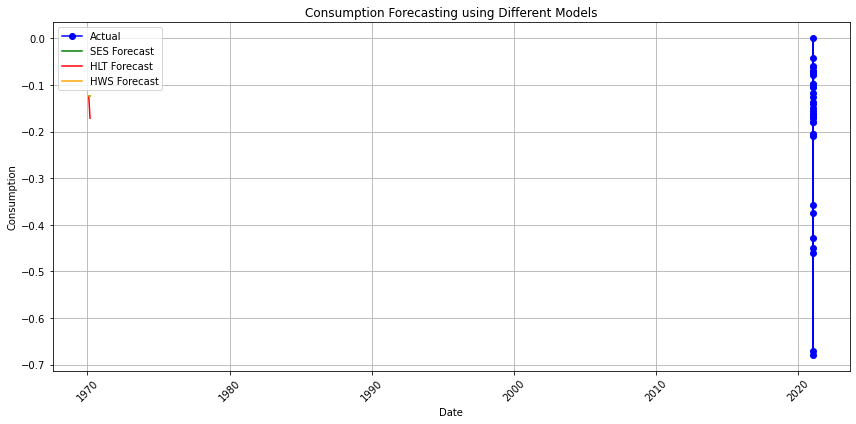

In [23]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

consumption = e_data['Consumption']
consumption = consumption[1990:2025]

ses_model = SimpleExpSmoothing(consumption)
ses_fit = ses_model.fit()

hlt_model = Holt(consumption)
hlt_fit = hlt_model.fit()

hws_model = ExponentialSmoothing(consumption, seasonal_periods=24)
hws_fit = hws_model.fit()

ses_forecast = ses_fit.forecast(steps=32)
hlt_forecast = hlt_fit.forecast(steps=32)
hws_forecast = hws_fit.forecast(steps=32)

print("Simple Exponential Smoothing (SES) Forecast:")
print(ses_forecast)
print("\nHolt's Linear Trend (HLT) Forecast:")
print(hlt_forecast)
print("\nHolt-Winters' Seasonal (HWS) Forecast:")
print(hws_forecast)

plt.figure(figsize=(12, 6))
plt.plot(consumption.index, consumption, label='Actual', marker='o', color='blue')
plt.plot(ses_forecast.index, ses_forecast, label='SES Forecast', color='green')
plt.plot(hlt_forecast.index, hlt_forecast, label="HLT Forecast", color='red')
plt.plot(hws_forecast.index, hws_forecast, label="HWS Forecast", color='orange')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Consumption Forecasting using Different Models')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save the plot as 'etsene.png'
plt.savefig('etsene.png')

plt.show()


#### Co2 Data

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

Simple Exponential Smoothing (SES) Forecast:
9997    -0.479188
9998    -0.479188
9999    -0.479188
10000   -0.479188
10001   -0.479188
10002   -0.479188
10003   -0.479188
10004   -0.479188
10005   -0.479188
10006   -0.479188
10007   -0.479188
10008   -0.479188
10009   -0.479188
10010   -0.479188
10011   -0.479188
10012   -0.479188
10013   -0.479188
10014   -0.479188
10015   -0.479188
10016   -0.479188
10017   -0.479188
10018   -0.479188
10019   -0.479188
10020   -0.479188
10021   -0.479188
10022   -0.479188
10023   -0.479188
10024   -0.479188
10025   -0.479188
10026   -0.479188
10027   -0.479188
10028   -0.479188
dtype: float64

Holt's Linear Trend (HLT) Forecast:
9997    -0.478884
9998    -0.478881
9999    -0.478879
10000   -0.478876
10001   -0.478874
10002   -0.478872
10003   -0.478869
10004   -0.478867
10005   -0.478864
10006   -0.478862
10007   -0.478859
10008   -0.478857
10009   -0.478854
10010   -0.478852
10011   -0.478849
10012   -0.478847
10013   -0.478844
10014   -0.478842
100

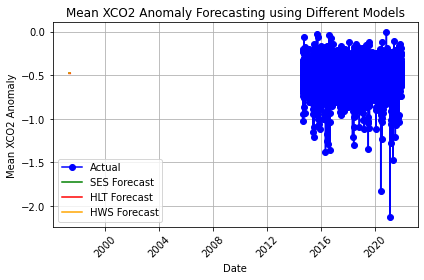

In [ ]:
mean_xco2_anomaly = ev_data['mean_xco2_anomaly']
ses_model = SimpleExpSmoothing(mean_xco2_anomaly)
ses_fit = ses_model.fit()
hlt_model = Holt(mean_xco2_anomaly)
hlt_fit = hlt_model.fit()
hws_model = ExponentialSmoothing(mean_xco2_anomaly, seasonal_periods=12)
hws_fit = hws_model.fit()
ses_forecast = ses_fit.forecast(steps=32)
hlt_forecast = hlt_fit.forecast(steps=32)
hws_forecast = hws_fit.forecast(steps=32)
print("Simple Exponential Smoothing (SES) Forecast:")
print(ses_forecast)
print("\nHolt's Linear Trend (HLT) Forecast:")
print(hlt_forecast)
print("\nHolt-Winters' Seasonal (HWS) Forecast:")
print(hws_forecast)
plt.plot(mean_xco2_anomaly.index, mean_xco2_anomaly, label='Actual', marker='o', color='blue')
plt.plot(ses_forecast.index, ses_forecast, label='SES Forecast', color='green')
plt.plot(hlt_forecast.index, hlt_forecast, label="HLT Forecast", color='red')
plt.plot(hws_forecast.index, hws_forecast, label="HWS Forecast", color='orange')
plt.xlabel('Date')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('Mean XCO2 Anomaly Forecasting using Different Models')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

Simple Exponential Smoothing (SES) Forecast:
9998    -0.195026
9999    -0.195026
10000   -0.195026
10001   -0.195026
10002   -0.195026
10003   -0.195026
10004   -0.195026
10005   -0.195026
10006   -0.195026
10007   -0.195026
10008   -0.195026
10009   -0.195026
10010   -0.195026
10011   -0.195026
10012   -0.195026
10013   -0.195026
10014   -0.195026
10015   -0.195026
10016   -0.195026
10017   -0.195026
10018   -0.195026
10019   -0.195026
10020   -0.195026
10021   -0.195026
10022   -0.195026
10023   -0.195026
10024   -0.195026
10025   -0.195026
10026   -0.195026
10027   -0.195026
10028   -0.195026
10029   -0.195026
dtype: float64

Holt's Linear Trend (HLT) Forecast:
9998    -0.194954
9999    -0.194953
10000   -0.194953
10001   -0.194952
10002   -0.194951
10003   -0.194951
10004   -0.194950
10005   -0.194950
10006   -0.194949
10007   -0.194949
10008   -0.194948
10009   -0.194948
10010   -0.194947
10011   -0.194947
10012   -0.194946
10013   -0.194945
10014   -0.194945
10015   -0.194944
100

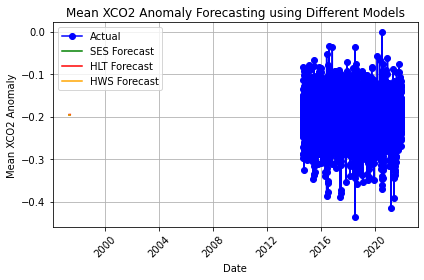

In [24]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

mean_xco2_anomaly = ev_data['mean_xco2_anomaly']

ses_model = SimpleExpSmoothing(mean_xco2_anomaly)
ses_fit = ses_model.fit()

hlt_model = Holt(mean_xco2_anomaly)
hlt_fit = hlt_model.fit()

hws_model = ExponentialSmoothing(mean_xco2_anomaly, seasonal_periods=12)
hws_fit = hws_model.fit()

ses_forecast = ses_fit.forecast(steps=32)
hlt_forecast = hlt_fit.forecast(steps=32)
hws_forecast = hws_fit.forecast(steps=32)

print("Simple Exponential Smoothing (SES) Forecast:")
print(ses_forecast)
print("\nHolt's Linear Trend (HLT) Forecast:")
print(hlt_forecast)
print("\nHolt-Winters' Seasonal (HWS) Forecast:")
print(hws_forecast)

plt.plot(mean_xco2_anomaly.index, mean_xco2_anomaly, label='Actual', marker='o', color='blue')
plt.plot(ses_forecast.index, ses_forecast, label='SES Forecast', color='green')
plt.plot(hlt_forecast.index, hlt_forecast, label="HLT Forecast", color='red')
plt.plot(hws_forecast.index, hws_forecast, label="HWS Forecast", color='orange')
plt.xlabel('Date')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('Mean XCO2 Anomaly Forecasting using Different Models')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save the plot as 'etsco.png'
plt.savefig('etsco.png')

plt.show()


In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

# Function to save the plot as an image file and return its binary data
def save_plot_to_bytes(figure):
    buffer = BytesIO()
    figure.savefig(buffer, format='png')
    buffer.seek(0)
    return buffer.read()

# Function to save forecasts into the database
def save_forecasts_to_db(connection, model_name, forecasts):
    cursor = connection.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS forecasts (
                        id INTEGER PRIMARY KEY,
                        model_name TEXT,
                        forecast BLOB
                    )''')
    for forecast in forecasts:
        plot_data = save_plot_to_bytes(forecast)
        cursor.execute("INSERT INTO forecasts (model_name, forecast) VALUES (?, ?)", (model_name, sqlite3.Binary(plot_data)))
    connection.commit()
    cursor.close()

# Forecasting and plotting for financial data
ses_model = SimpleExpSmoothing(close_last)
ses_fit = ses_model.fit()
hlt_model = Holt(close_last)
hlt_fit = hlt_model.fit()
hws_model = ExponentialSmoothing(close_last, seasonal_periods=12)
hws_fit = hws_model.fit()
ses_forecast = ses_fit.forecast(steps=32)
hlt_forecast = hlt_fit.forecast(steps=32)
hws_forecast = hws_fit.forecast(steps=32)
plt.plot(close_last.index, close_last, label='Actual', marker='o', color='blue')
plt.plot(ses_forecast.index, ses_forecast, label='SES Forecast', color='green')
plt.plot(hlt_forecast.index, hlt_forecast, label="HLT Forecast", color='red')
plt.plot(hws_forecast.index, hws_forecast, label="HWS Forecast", color='orange')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.title('Forecasting using Different Models (Financial Data)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("financial_forecast.png")
plt.close()

# Forecasting and plotting for energy consumption data
ses_model = SimpleExpSmoothing(consumption)
ses_fit = ses_model.fit()
hlt_model = Holt(consumption)
hlt_fit = hlt_model.fit()
hws_model = ExponentialSmoothing(consumption, seasonal_periods=24)
hws_fit = hws_model.fit()
ses_forecast = ses_fit.forecast(steps=32)
hlt_forecast = hlt_fit.forecast(steps=32)
hws_forecast = hws_fit.forecast(steps=32)
plt.figure(figsize=(12, 6))
plt.plot(consumption.index, consumption, label='Actual', marker='o', color='blue')
plt.plot(ses_forecast.index, ses_forecast, label='SES Forecast', color='green')
plt.plot(hlt_forecast.index, hlt_forecast, label="HLT Forecast", color='red')
plt.plot(hws_forecast.index, hws_forecast, label="HWS Forecast", color='orange')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Consumption Forecasting using Different Models (Energy Data)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("energy_forecast.png")
plt.close()

# Forecasting and plotting for CO2 anomaly data
ses_model = SimpleExpSmoothing(mean_xco2_anomaly)
ses_fit = ses_model.fit()
hlt_model = Holt(mean_xco2_anomaly)
hlt_fit = hlt_model.fit()
hws_model = ExponentialSmoothing(mean_xco2_anomaly, seasonal_periods=12)
hws_fit = hws_model.fit()
ses_forecast = ses_fit.forecast(steps=32)
hlt_forecast = hlt_fit.forecast(steps=32)
hws_forecast = hws_fit.forecast(steps=32)
plt.plot(mean_xco2_anomaly.index, mean_xco2_anomaly, label='Actual', marker='o', color='blue')
plt.plot(ses_forecast.index, ses_forecast, label='SES Forecast', color='green')
plt.plot(hlt_forecast.index, hlt_forecast, label="HLT Forecast", color='red')
plt.plot(hws_forecast.index, hws_forecast, label="HWS Forecast", color='orange')
plt.xlabel('Date')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('Mean XCO2 Anomaly Forecasting using Different Models')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("co2_forecast.png")
plt.close()

# Save forecasts to databases
conn_financial = sqlite3.connect("ETS_fin.db")
save_forecasts_to_db(conn_financial, "Financial Forecast", [plt])
conn_financial.close()

conn_energy = sqlite3.connect("ETS_energy.db")
save_forecasts_to_db(conn_energy, "Energy Forecast", [plt])
conn_energy.close()

conn_co2 = sqlite3.connect("ETS_CO2.db")
save_forecasts_to_db(conn_co2, "CO2 Forecast", [plt])
conn_co2.close()


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

<Figure size 432x288 with 0 Axes>

### Prophet

### Finance Data

17:17:22 - cmdstanpy - INFO - Chain [1] start processing
17:17:23 - cmdstanpy - INFO - Chain [1] done processing


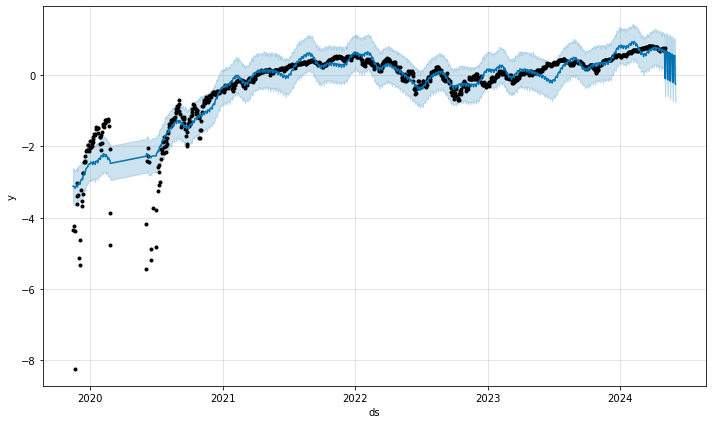

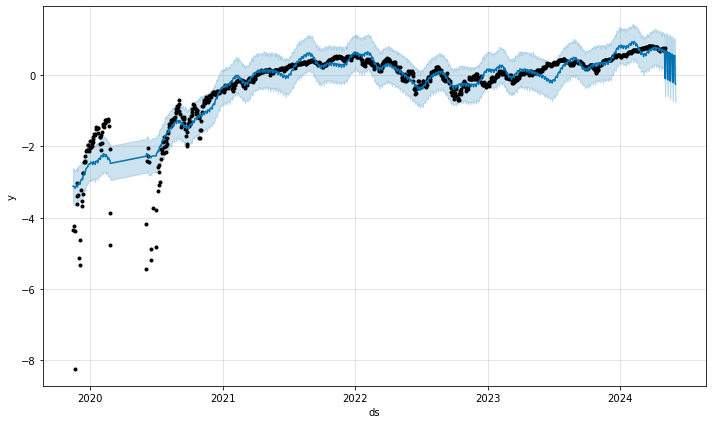

In [ ]:
f_data_prophet = f_data[['Date', 'Close/Last']].rename(columns={'Date': 'ds', 'Close/Last': 'y'})
model = Prophet()
model.fit(f_data_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
model.plot(forecast)

#### Energy Data

17:17:24 - cmdstanpy - INFO - Chain [1] start processing
17:17:25 - cmdstanpy - INFO - Chain [1] done processing


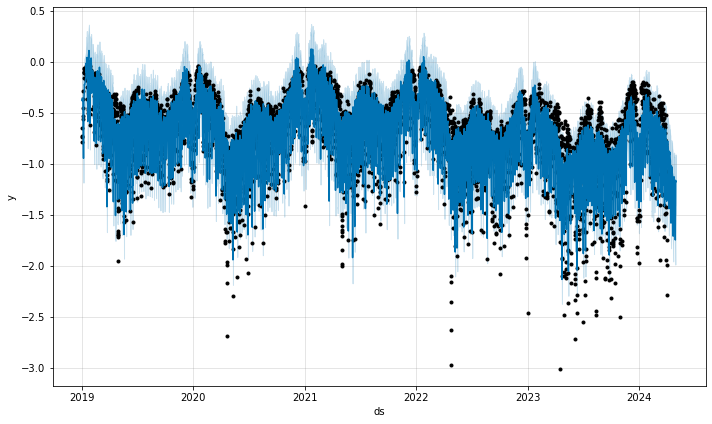

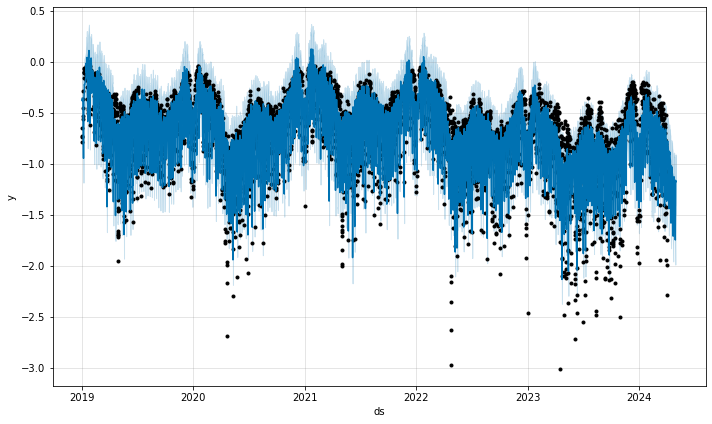

In [ ]:
e_data['DateTime'] = e_data.index
e_data_prophet = e_data[['DateTime', 'Consumption']].rename(columns={'DateTime': 'ds', 'Consumption': 'y'})
model = Prophet()
model.fit(e_data_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
model.plot(forecast)

#### Co2 Data

17:17:27 - cmdstanpy - INFO - Chain [1] start processing
17:17:28 - cmdstanpy - INFO - Chain [1] done processing


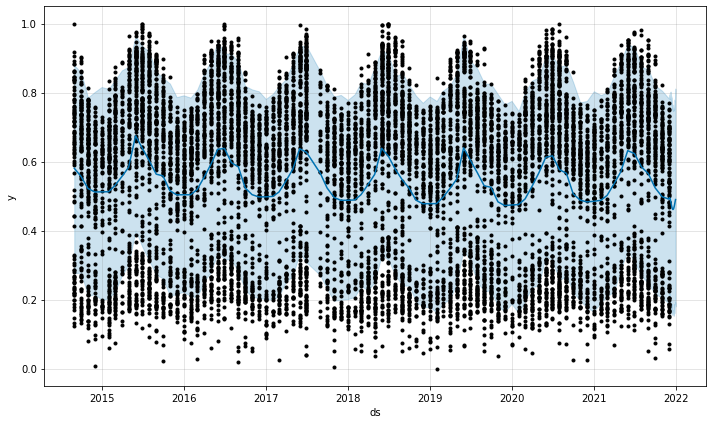

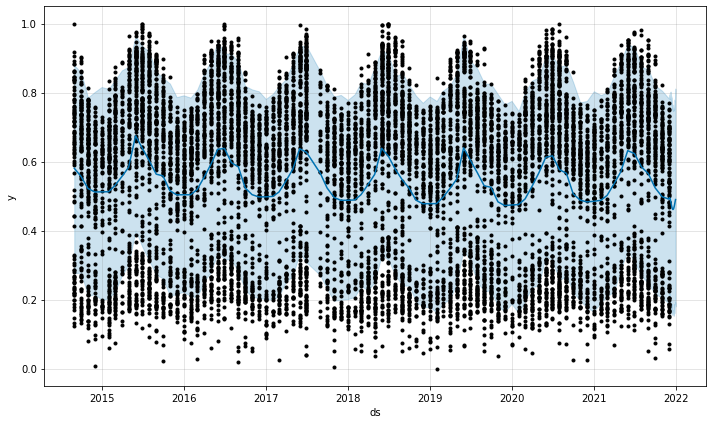

In [ ]:
ev_data['Date'] = ev_data.index
ev_data_prophet = ev_data[['Date', 'y']].rename(columns={'Date': 'ds', 'y': 'y'})
model = Prophet()
model.fit(ev_data_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
model.plot(forecast)

02:02:24 - cmdstanpy - INFO - Chain [1] start processing
02:02:25 - cmdstanpy - INFO - Chain [1] done processing
02:02:26 - cmdstanpy - INFO - Chain [1] start processing
02:02:28 - cmdstanpy - INFO - Chain [1] done processing
02:02:30 - cmdstanpy - INFO - Chain [1] start processing
02:02:31 - cmdstanpy - INFO - Chain [1] done processing


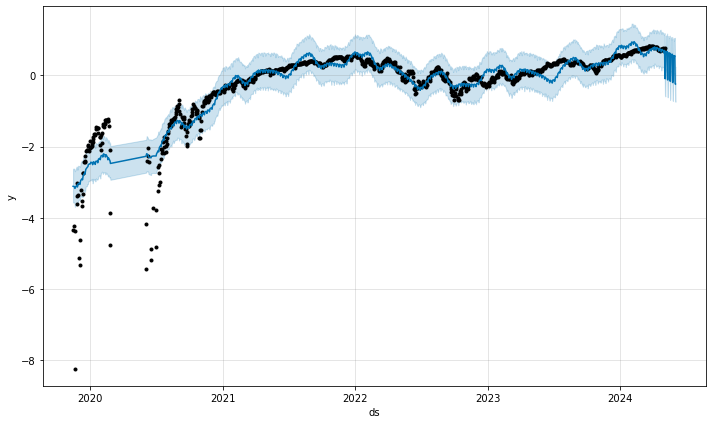

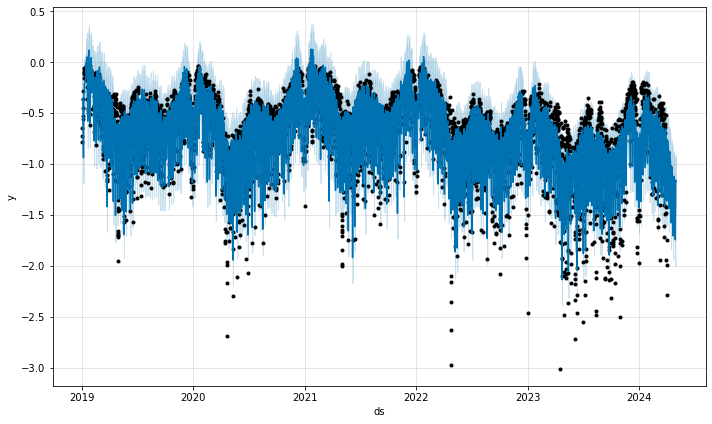

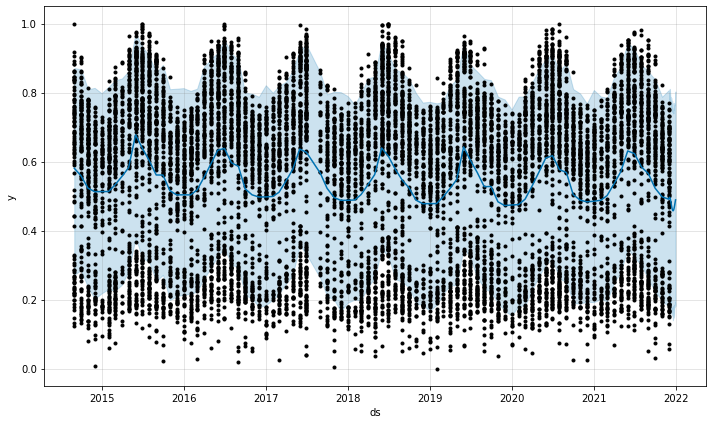

In [ ]:


# Function to save the plot as an image file and return its binary data
def save_plot_to_bytes(figure):
    buffer = BytesIO()
    figure.savefig(buffer, format='png')
    buffer.seek(0)
    return buffer.read()

# Function to save forecasts into the database
def save_forecasts_to_db(connection, model_name, forecast):
    cursor = connection.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS prophet_forecasts (
                        id INTEGER PRIMARY KEY,
                        model_name TEXT,
                        forecast BLOB
                    )''')
    plot_data = save_plot_to_bytes(forecast)
    cursor.execute("INSERT INTO prophet_forecasts (model_name, forecast) VALUES (?, ?)", (model_name, sqlite3.Binary(plot_data)))
    connection.commit()
    cursor.close()

# Prophet forecasting and plotting for financial data
f_data_prophet = f_data[['Date', 'Close/Last']].rename(columns={'Date': 'ds', 'Close/Last': 'y'})
model = Prophet()
model.fit(f_data_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
fig = model.plot(forecast)

# Save Prophet financial forecast plot to SQLite database
conn_financial = sqlite3.connect("prophet_fin.db")
save_forecasts_to_db(conn_financial, "Prophet Financial Forecast", fig)
conn_financial.close()

# Prophet forecasting and plotting for energy consumption data
e_data_prophet = e_data[['DateTime', 'Consumption']].rename(columns={'DateTime': 'ds', 'Consumption': 'y'})
model = Prophet()
model.fit(e_data_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
fig = model.plot(forecast)

# Save Prophet energy consumption forecast plot to SQLite database
conn_energy = sqlite3.connect("prophet_energy.db")
save_forecasts_to_db(conn_energy, "Prophet Energy Forecast", fig)
conn_energy.close()

# Prophet forecasting and plotting for CO2 data
ev_data_prophet = ev_data[['Date', 'y']].rename(columns={'Date': 'ds', 'y': 'y'})
model = Prophet()
model.fit(ev_data_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
fig = model.plot(forecast)

# Save Prophet CO2 forecast plot to SQLite database
conn_co2 = sqlite3.connect("prophet_co2.db")
save_forecasts_to_db(conn_co2, "Prophet CO2 Forecast", fig)
conn_co2.close()


19:29:40 - cmdstanpy - INFO - Chain [1] start processing
19:29:40 - cmdstanpy - INFO - Chain [1] done processing


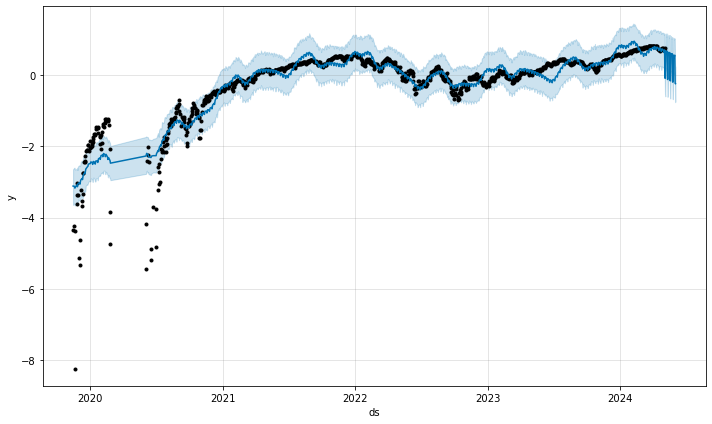

19:29:41 - cmdstanpy - INFO - Chain [1] start processing
19:29:43 - cmdstanpy - INFO - Chain [1] done processing


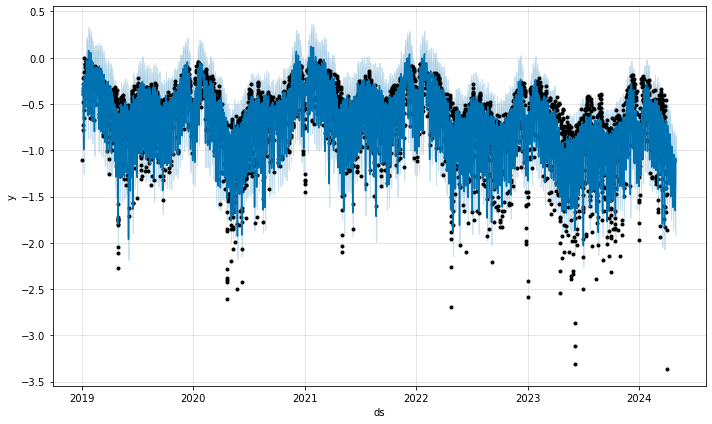

19:29:45 - cmdstanpy - INFO - Chain [1] start processing
19:29:46 - cmdstanpy - INFO - Chain [1] done processing


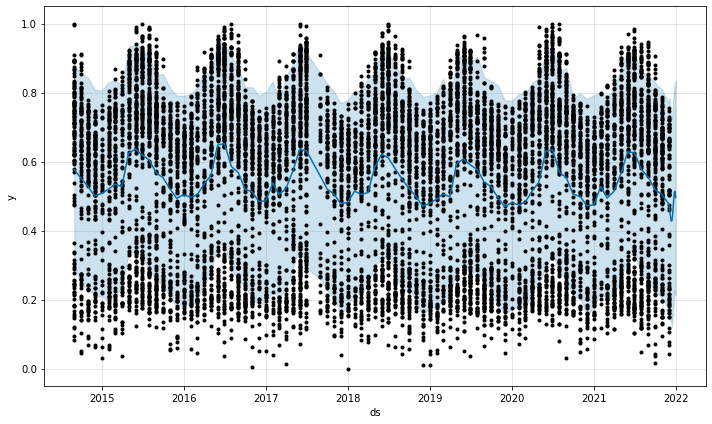

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.9.1-py3-none-any.whl (13 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)

  Using cached pystan-3.7.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.6.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.5.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.4.0-py3-none-any.whl (13 kB)
  Using cached pysimdjson-3.2.0-cp39-cp39-win_amd64.whl (157 kB)
  Using cached pystan-3.0.1-py3-none-any.whl (12 kB)

  Using cached pystan-3.9.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.8.0-py3-none-any.whl (13 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\hysam\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\hysam\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "C:\Users\hysam\anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "C:\Users\hysam\anaconda3\lib\http\client.py", line 463, in read
    n = self.readinto(b)
  File "C:\Users\hysam\anaconda3\lib\http\client.py", line 507, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\hysam\anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\hysam\anaconda3\lib\ssl.py", line 1241, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Users\hysam\anaconda3\lib\ssl.py", line 1099, in read
    return self._sslobj.read(len, buffer)
soc

In [31]:

import matplotlib.pyplot as plt

f_data_prophet = f_data[['Date', 'Close/Last']].rename(columns={'Date': 'ds', 'Close/Last': 'y'})
model = Prophet()
model.fit(f_data_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

fig = model.plot(forecast)
plt.savefig('profin.png')  # Save the plot as 'profin.png'
plt.show()






e_data['DateTime'] = e_data.index
e_data_prophet = e_data[['DateTime', 'Consumption']].rename(columns={'DateTime': 'ds', 'Consumption': 'y'})

model = Prophet()
model.fit(e_data_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

fig = model.plot(forecast)
plt.savefig('profene.png')  # Save the plot as 'profene.png'
plt.show()







ev_data['Date'] = ev_data.index
ev_data_prophet = ev_data[['Date', 'y']].rename(columns={'Date': 'ds', 'y': 'y'})

model = Prophet()
model.fit(ev_data_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

fig = model.plot(forecast)
plt.savefig('profco.png')  # Save the plot as 'profco2.png'
plt.show()


In [29]:
!pip install fbprophet

^C


### Support Vector Regression (SVR)

### Finance Data

Mean squared error: 0.11881131585220461


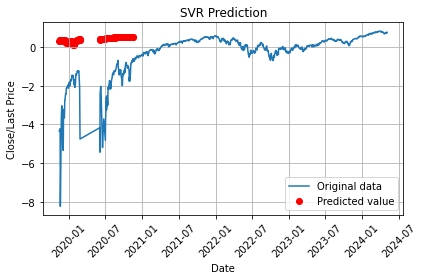

In [ ]:
X = f_data[['Open', 'High', 'Low']].values
y = f_data['Close/Last'].values
def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)
model = svr(X, y, C=1.0, kernel='rbf', gamma=0.1)
X_pred = f_data[['Open', 'High', 'Low']].tail(1).values
y_pred = model.predict(X_pred)
tscv = TimeSeriesSplit(n_splits=5)
scores = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)
print('Mean squared error:', np.mean(scores))
plt.plot(f_data.index, f_data['Close/Last'], label='Original data')
plt.scatter( f_data.index[0:173],y_pred, color='red', label='Predicted value')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.title('SVR Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Energy Data

Mean squared error: 0.9187073061783074


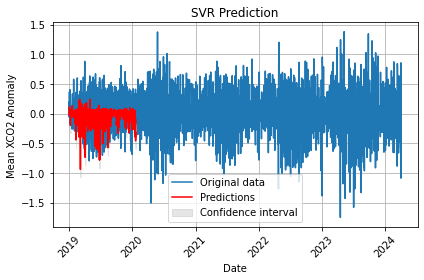

In [ ]:
X = e_data[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']].values
y = e_data['diff_Consumption'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)

model = svr(X, y, C=1.0, kernel='rbf', gamma=0.1)
X_pred = np.array([e_data[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']].tail(1).values[0]])
y_pred = model.predict(X_pred)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)

print('Mean squared error:', np.mean(scores))
upper_bound = y_pred + np.std(y_pred)
lower_bound = y_pred - np.std(y_pred)
a = y_pred.size
plt.plot(e_data.index, e_data['diff_Consumption'], label='Original data')
plt.plot(e_data.index[0:a], y_pred, color='red', label='Predictions')
plt.fill_between(e_data.index[0:a], upper_bound, lower_bound, color='gray', alpha=0.2, label='Confidence interval')

plt.xlabel('Date')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('SVR Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Co2 Data

Mean squared error: 1.2589986522992276


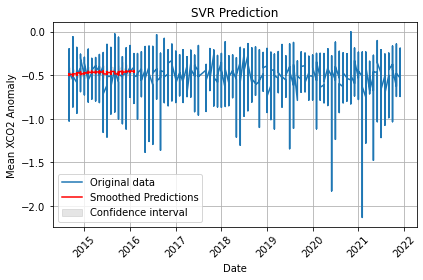

In [ ]:
X = ev_data[['x', 'y', 'mean_xco2']].values
y = ev_data['mean_xco2_anomaly'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()
def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)
model = svr(X, y, C=1.0, kernel='rbf', gamma=0.1)
X_pred = np.array([ev_data[['x', 'y', 'mean_xco2']].tail(1).values[0]])
y_pred = model.predict(X_pred)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)
print('Mean squared error:', np.mean(scores))
upper_bound = y_pred + np.std(y_pred)
lower_bound = y_pred - np.std(y_pred)

smoothed_y_pred = gaussian_filter1d(y_pred, sigma=3)

plt.plot(ev_data.index, ev_data['mean_xco2_anomaly'], label='Original data')
plt.plot(ev_data.index[0:1999], smoothed_y_pred, color='red', label='Smoothed Predictions')
plt.fill_between(ev_data.index[0:1999], upper_bound, lower_bound, color='gray', alpha=0.2, label='Confidence interval')

plt.xlabel('Date')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('SVR Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Mean squared error: 0.11881131585220461


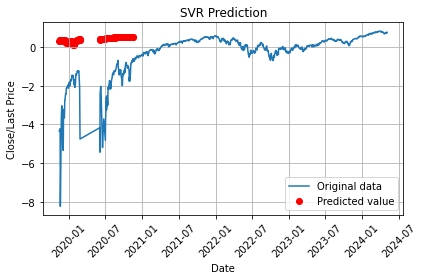

In [32]:
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt

X = f_data[['Open', 'High', 'Low']].values
y = f_data['Close/Last'].values

def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)

model = svr(X, y, C=1.0, kernel='rbf', gamma=0.1)
X_pred = f_data[['Open', 'High', 'Low']].tail(1).values
y_pred = model.predict(X_pred)

tscv = TimeSeriesSplit(n_splits=5)
scores = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)

print('Mean squared error:', np.mean(scores))

plt.plot(f_data.index, f_data['Close/Last'], label='Original data')
plt.scatter(f_data.index[0:173], y_pred, color='red', label='Predicted value')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.title('SVR Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save the plot as 'svrfin.png'
plt.savefig('svrfin.png')

plt.show()






Mean squared error: 0.9197315292441504


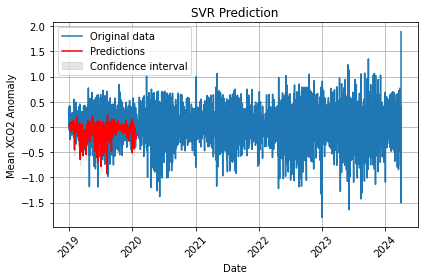

Mean squared error: 1.0379815091961981


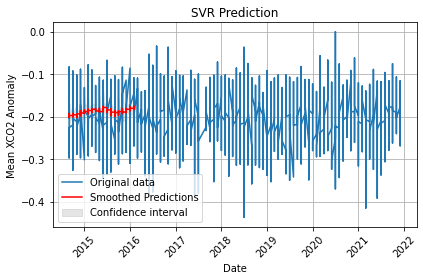

In [34]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

X = e_data[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']].values
y = e_data['diff_Consumption'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)

model = svr(X, y, C=1.0, kernel='rbf', gamma=0.1)
X_pred = np.array([e_data[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']].tail(1).values[0]])
y_pred = model.predict(X_pred)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)

print('Mean squared error:', np.mean(scores))

upper_bound = y_pred + np.std(y_pred)
lower_bound = y_pred - np.std(y_pred)
a = y_pred.size

plt.plot(e_data.index, e_data['diff_Consumption'], label='Original data')
plt.plot(e_data.index[0:a], y_pred, color='red', label='Predictions')
plt.fill_between(e_data.index[0:a], upper_bound, lower_bound, color='gray', alpha=0.2, label='Confidence interval')

plt.xlabel('Date')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('SVR Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save the plot as 'svrene.png'
plt.savefig('svrene.png')

plt.show()



X = ev_data[['x', 'y', 'mean_xco2']].values
y = ev_data['mean_xco2_anomaly'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)

model = svr(X, y, C=1.0, kernel='rbf', gamma=0.1)
X_pred = np.array([ev_data[['x', 'y', 'mean_xco2']].tail(1).values[0]])
y_pred = model.predict(X_pred)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)

print('Mean squared error:', np.mean(scores))

upper_bound = y_pred + np.std(y_pred)
lower_bound = y_pred - np.std(y_pred)

smoothed_y_pred = gaussian_filter1d(y_pred, sigma=3)

plt.plot(ev_data.index, ev_data['mean_xco2_anomaly'], label='Original data')
plt.plot(ev_data.index[0:1999], smoothed_y_pred, color='red', label='Smoothed Predictions')
plt.fill_between(ev_data.index[0:1999], upper_bound, lower_bound, color='gray', alpha=0.2, label='Confidence interval')

plt.xlabel('Date')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('SVR Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save the plot as 'svrco.png'
plt.savefig('svrco.png')

plt.show()


Mean squared error: 0.11881131585220461


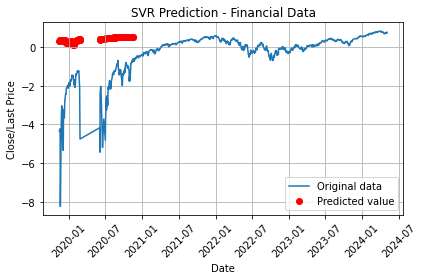

Mean squared error: 0.9197315292441504


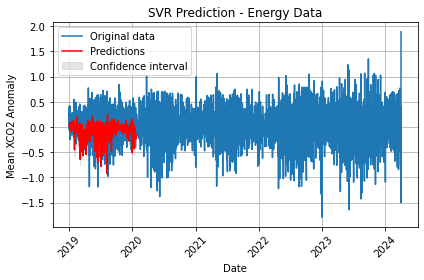

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [33]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter1d
from io import BytesIO

# Connect to or create SQLite databases
databases = ['svr-fin.db', 'svr-energy.db', 'svr-co2.db']
for db in databases:
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS graphs (
                        id INTEGER PRIMARY KEY,
                        image BLOB,
                        description TEXT
                    )''')
    conn.commit()
    conn.close()

# Function to save and insert graph into SQLite database
def save_insert_graph(db_name, graph, description):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    # Convert graph to binary data
    buffer = BytesIO()
    graph.savefig(buffer, format='png')
    buffer.seek(0)
    image_binary = buffer.read()
    # Insert graph into database
    cursor.execute("INSERT INTO graphs (image, description) VALUES (?, ?)", (sqlite3.Binary(image_binary), description))
    conn.commit()
    conn.close()

# Snippet 1: Financial Data
X = f_data[['Open', 'High', 'Low']].values
y = f_data['Close/Last'].values
def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)
model = svr(X, y, C=1.0, kernel='rbf', gamma=0.1)
X_pred = f_data[['Open', 'High', 'Low']].tail(1).values
y_pred = model.predict(X_pred)
tscv = TimeSeriesSplit(n_splits=5)
scores = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)
print('Mean squared error:', np.mean(scores))
plt.plot(f_data.index, f_data['Close/Last'], label='Original data')
plt.scatter(f_data.index[0:173], y_pred, color='red', label='Predicted value')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.title('SVR Prediction - Financial Data')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
save_insert_graph('svr-fin.db', plt, 'SVR Prediction - Financial Data')

# Snippet 2: Energy Data
X = e_data[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']].values
y = e_data['diff_Consumption'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)

model = svr(X, y, C=1.0, kernel='rbf', gamma=0.1)
X_pred = np.array([e_data[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']].tail(1).values[0]])
y_pred = model.predict(X_pred)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)

print('Mean squared error:', np.mean(scores))
upper_bound = y_pred + np.std(y_pred)
lower_bound = y_pred - np.std(y_pred)
a = y_pred.size
plt.plot(e_data.index, e_data['diff_Consumption'], label='Original data')
plt.plot(e_data.index[0:a], y_pred, color='red', label='Predictions')
plt.fill_between(e_data.index[0:a], upper_bound, lower_bound, color='gray', alpha=0.2, label='Confidence interval')

plt.xlabel('Date')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('SVR Prediction - Energy Data')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
save_insert_graph('svr-energy.db', plt, 'SVR Prediction - Energy Data')

# Snippet 3: CO2 Data
X = ev_data[['x', 'y', 'mean_xco2']].values
y = ev_data['mean_xco2_anomaly'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()
def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)
model = svr(X, y, C=1.0, kernel='rbf', gamma=0.1)
X_pred = np.array([ev_data[['x', 'y', 'mean_xco2']].tail(1).values[0]])
y_pred = model.predict(X_pred)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)
print('Mean squared error:', np.mean(scores))
upper_bound = y_pred + np.std(y_pred)
lower_bound = y_pred - np.std(y_pred)

smoothed_y_pred = gaussian_filter1d(y_pred, sigma=3)

plt.plot(ev_data.index, ev_data['mean_xco2_anomaly'], label='Original data')
plt.plot(ev_data.index[0:1999], smoothed_y_pred, color='red', label='Smoothed Predictions')
plt.fill_between(ev_data.index[0:1999], upper_bound, lower_bound, color='gray', alpha=0.2, label='Confidence interval')

plt.xlabel('Date')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('SVR Prediction - CO2 Data')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
save_insert_graph('svr-co2.db', plt, 'SVR Prediction - CO2 Data')

print("Graphs stored in databases successfully.")


#### Long Short-Term Memory (LSTM)

#### Finance Data

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
[[0.48227322]]


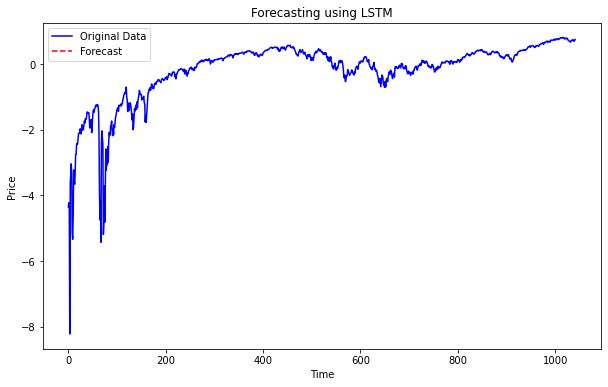

In [ ]:
data = f_data['Close/Last'].values
sequence_length = 50
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, verbose=0)
forecast_sequence = data[-sequence_length:]
forecast_sequence = np.array(forecast_sequence).reshape((1, sequence_length, 1))
forecast_sequence = (forecast_sequence - mean) / std
forecast = model.predict(forecast_sequence)
forecast = forecast * std + mean
print(forecast)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)), data, color='blue', label='Original Data')
plt.plot(np.arange(len(data), len(data) + len(forecast[0])), forecast[0], color='red', label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Forecasting using LSTM')
plt.legend()
plt.show()

#### Energy Data

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
[[-1.270847]]


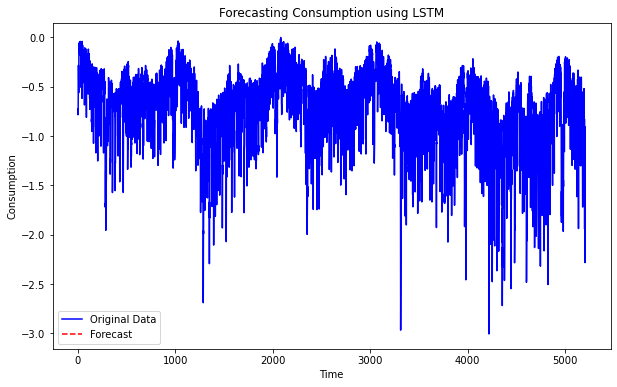

In [ ]:
data = e_data['Consumption'].values
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, verbose=0)
forecast_sequence = data[-sequence_length:]
forecast_sequence = np.array(forecast_sequence).reshape((1, sequence_length, 1))
forecast_sequence = (forecast_sequence - mean) / std
forecast = model.predict(forecast_sequence)
forecast = forecast * std + mean
print(forecast)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)), data, color='blue', label='Original Data')
plt.plot(np.arange(len(data), len(data) + len(forecast[0])), forecast[0], color='red', label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Forecasting Consumption using LSTM')
plt.legend()
plt.show()

#### Co2 Data

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
[[-0.56764877]]


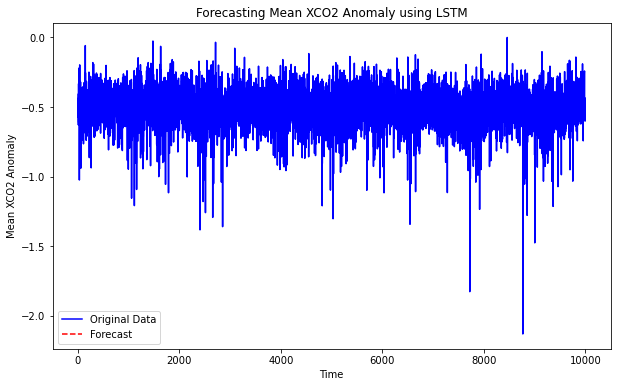

In [ ]:
data = ev_data['mean_xco2_anomaly'].values
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, verbose=0)
forecast_sequence = data[-sequence_length:]
forecast_sequence = np.array(forecast_sequence).reshape((1, sequence_length, 1))
forecast_sequence = (forecast_sequence - mean) / std
forecast = model.predict(forecast_sequence)
forecast = forecast * std + mean
print(forecast)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)), data, color='blue', label='Original Data')
plt.plot(np.arange(len(data), len(data) + len(forecast[0])), forecast[0], color='red', label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('Forecasting Mean XCO2 Anomaly using LSTM')
plt.legend()
plt.show()

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


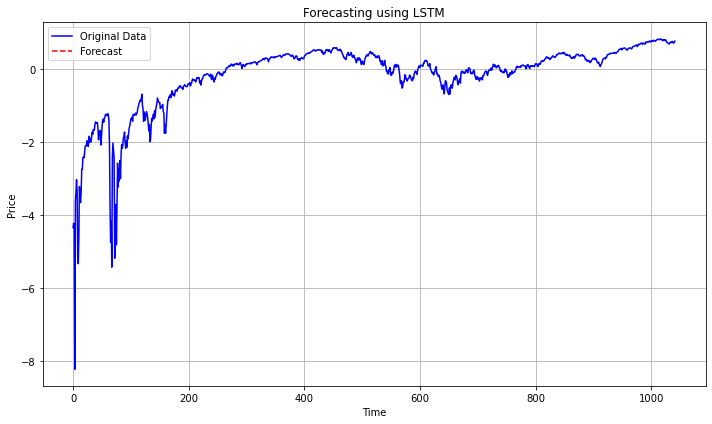

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


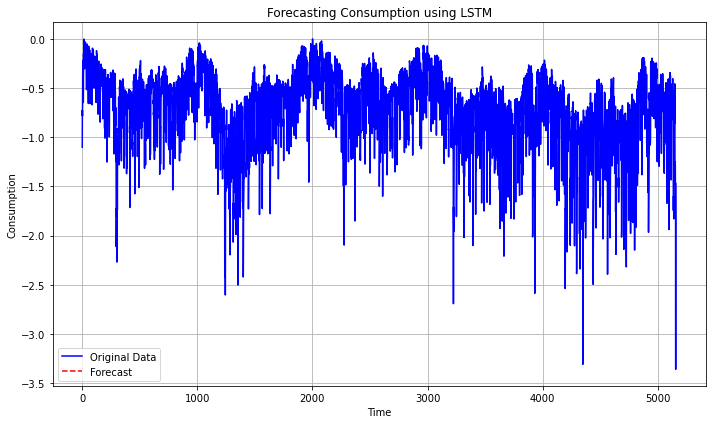

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


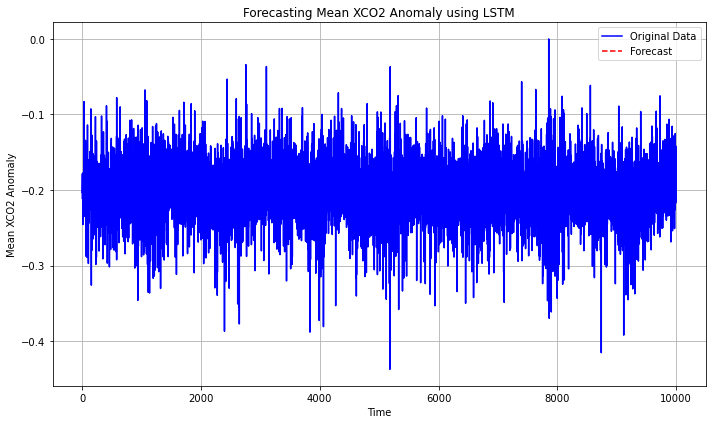

In [35]:
data = f_data['Close/Last'].values
sequence_length = 50
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, verbose=0)

forecast_sequence = data[-sequence_length:]
forecast_sequence = np.array(forecast_sequence).reshape((1, sequence_length, 1))
forecast_sequence = (forecast_sequence - mean) / std
forecast = model.predict(forecast_sequence)
forecast = forecast * std + mean

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)), data, color='blue', label='Original Data')
plt.plot(np.arange(len(data), len(data) + len(forecast[0])), forecast[0], color='red', label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Forecasting using LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot as 'lfin.png'
plt.savefig('lfin.png')

plt.show()



data = e_data['Consumption'].values
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, verbose=0)

forecast_sequence = data[-sequence_length:]
forecast_sequence = np.array(forecast_sequence).reshape((1, sequence_length, 1))
forecast_sequence = (forecast_sequence - mean) / std
forecast = model.predict(forecast_sequence)
forecast = forecast * std + mean

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)), data, color='blue', label='Original Data')
plt.plot(np.arange(len(data), len(data) + len(forecast[0])), forecast[0], color='red', label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Forecasting Consumption using LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot as 'lene.png'
plt.savefig('lene.png')

plt.show()




data = ev_data['mean_xco2_anomaly'].values
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, verbose=0)

forecast_sequence = data[-sequence_length:]
forecast_sequence = np.array(forecast_sequence).reshape((1, sequence_length, 1))
forecast_sequence = (forecast_sequence - mean) / std
forecast = model.predict(forecast_sequence)
forecast = forecast * std + mean

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)), data, color='blue', label='Original Data')
plt.plot(np.arange(len(data), len(data) + len(forecast[0])), forecast[0], color='red', label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('Forecasting Mean XCO2 Anomaly using LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot as 'lco.png'
plt.savefig('lco.png')

plt.show()


C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


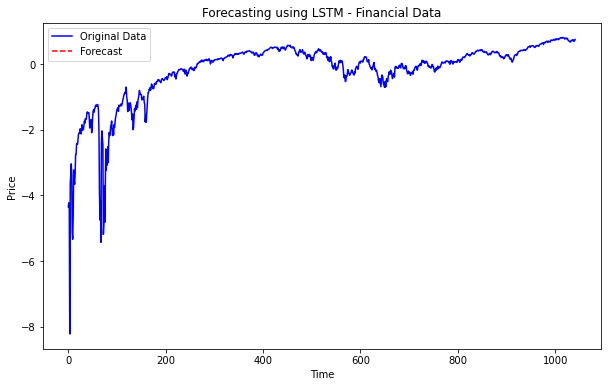

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


<Figure size 432x288 with 0 Axes>

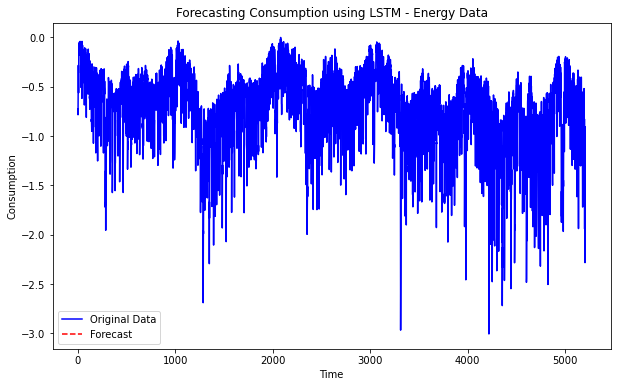

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


<Figure size 432x288 with 0 Axes>

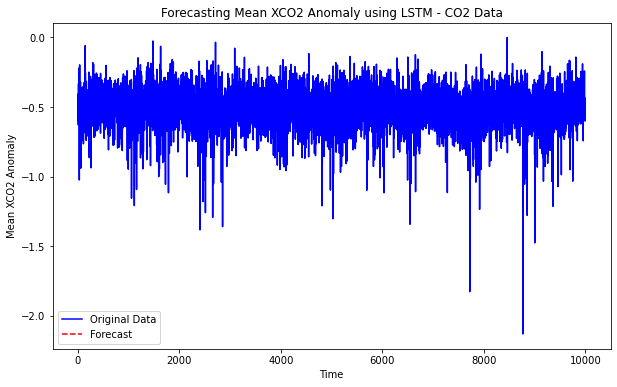

Graphs stored in databases successfully.


<Figure size 432x288 with 0 Axes>

In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from io import BytesIO

# Connect to or create SQLite databases
databases = ['lstm-fin.db', 'lstm-energy.db', 'lstm-co2.db']
for db in databases:
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS graphs (
                        id INTEGER PRIMARY KEY,
                        image BLOB,
                        description TEXT
                    )''')
    conn.commit()
    conn.close()

# Function to save and insert graph into SQLite database
def save_insert_graph(db_name, graph, description):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    # Convert graph to binary data
    buffer = BytesIO()
    graph.savefig(buffer, format='png')
    buffer.seek(0)
    image_binary = buffer.read()
    # Insert graph into database
    cursor.execute("INSERT INTO graphs (image, description) VALUES (?, ?)", (sqlite3.Binary(image_binary), description))
    conn.commit()
    conn.close()

# Snippet 1: Financial Data
data = f_data['Close/Last'].values
sequence_length = 50
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X.reshape((X.shape[0], X.shape[1], 1)), y, epochs=50, verbose=0)
forecast_sequence = data[-sequence_length:]
forecast_sequence = np.array(forecast_sequence).reshape((1, sequence_length, 1))
forecast_sequence = (forecast_sequence - mean) / std
forecast = model.predict(forecast_sequence)
forecast = forecast * std + mean
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)), data, color='blue', label='Original Data')
plt.plot(np.arange(len(data), len(data) + len(forecast[0])), forecast[0], color='red', label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Forecasting using LSTM - Financial Data')
plt.legend()
plt.show()
save_insert_graph('lstm-fin.db', plt, 'Forecasting using LSTM - Financial Data')

# Snippet 2: Energy Data
data = e_data['Consumption'].values
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X.reshape((X.shape[0], X.shape[1], 1)), y, epochs=50, verbose=0)
forecast_sequence = data[-sequence_length:]
forecast_sequence = np.array(forecast_sequence).reshape((1, sequence_length, 1))
forecast_sequence = (forecast_sequence - mean) / std
forecast = model.predict(forecast_sequence)
forecast = forecast * std + mean
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)), data, color='blue', label='Original Data')
plt.plot(np.arange(len(data), len(data) + len(forecast[0])), forecast[0], color='red', label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Forecasting Consumption using LSTM - Energy Data')
plt.legend()
plt.show()
save_insert_graph('lstm-energy.db', plt, 'Forecasting Consumption using LSTM - Energy Data')

# Snippet 3: CO2 Data
data = ev_data['mean_xco2_anomaly'].values
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X.reshape((X.shape[0], X.shape[1], 1)), y, epochs=50, verbose=0)
forecast_sequence = data[-sequence_length:]
forecast_sequence = np.array(forecast_sequence).reshape((1, sequence_length, 1))
forecast_sequence = (forecast_sequence - mean) / std
forecast = model.predict(forecast_sequence)
forecast = forecast * std + mean
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)), data, color='blue', label='Original Data')
plt.plot(np.arange(len(data), len(data) + len(forecast[0])), forecast[0], color='red', label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('Forecasting Mean XCO2 Anomaly using LSTM - CO2 Data')
plt.legend()
plt.show()
save_insert_graph('lstm-co2.db', plt, 'Forecasting Mean XCO2 Anomaly using LSTM - CO2 Data')

print("Graphs stored in databases successfully.")


In [8]:
from fastapi import FastAPI
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import io
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String
import matplotlib.pyplot as plt

# Create FastAPI app
app = FastAPI()

# SQLAlchemy setup
SQLALCHEMY_DATABASE_URL = "sqlite:///./test.db"
engine = create_engine(SQLALCHEMY_DATABASE_URL)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
Base = declarative_base()

# Define your database model
class Item(Base):
    __tablename__ = "items"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, index=True)

# Create tables
Base.metadata.create_all(bind=engine)

# FastAPI endpoint to plot a graph
@app.get("/plot")
async def plot_graph():
    # Retrieve data from the database
    db = SessionLocal()
    items = db.query(Item).all()
    db.close()

    # Process data
    names = [item.name for item in items]
    name_counts = {name: names.count(name) for name in set(names)}

    # Plot graph
    fig, ax = plt.subplots()
    ax.bar(name_counts.keys(), name_counts.values())
    ax.set_xlabel('Names')
    ax.set_ylabel('Counts')
    ax.set_title('Name Counts')
    
    # Convert plot to binary data
    output = io.BytesIO()
    FigureCanvas(fig).print_png(output)
    plt.close(fig)
    return output.getvalue()
print("hysam")


hysam


In [9]:

!pip install fastapi uvicorn matplotlib sqlalchemy


In [ ]:
f_data

Date  Close/Last      Open      High       Low
DateTime                                                       
2019-11-15 2019-11-15   -4.347105 -4.434511 -4.876154 -3.612794
2019-11-18 2019-11-18   -4.226541 -3.809880 -4.471993 -3.360786
2019-11-19 2019-11-19   -4.370221 -3.442730 -4.201236 -3.319544
2019-11-20 2019-11-20   -8.227307 -3.973726 -5.099327 -4.319527
2019-11-25 2019-11-25   -3.616827 -3.831978 -3.848379 -3.211805
...               ...         ...       ...       ...       ...
2024-04-29 2024-04-29    0.752002  0.731555  0.721877  0.733934
2024-04-30 2024-04-30    0.711096  0.726412  0.715560  0.707039
2024-05-01 2024-05-01    0.702080  0.688464  0.708170  0.695804
2024-05-02 2024-05-02    0.725779  0.698908  0.696550  0.694563
2024-05-03 2024-05-03    0.757772  0.735833  0.729621  0.740168

[1042 rows x 5 columns]

In [ ]:
data = f_data['Close/Last'].values

# Fit an ARIMA model to the data
model = ARIMA(data, order=(1,1,1))
model_fit = model.fit()

# Generate predictions using the ARIMA model
predictions = model_fit.predict(start=len(data)-10, end=len(data))

# Calculate the residuals
residuals = data[10:] - predictions[:-10]

# Normalize the residuals
mean = np.mean(residuals)
std = np.std(residuals)
residuals = (residuals - mean) / std
# Define the ANN model
ann_model = Sequential()
ann_model.add(LSTM(50, activation='relu', input_shape=(10, 1)))
ann_model.add(Dense(1))

# Compile the ANN model
ann_model.compile(optimizer='adam', loss='mse')
# Generate a sequence of input data points for forecasting
forecast_sequence = data[-10:]

# Reshape the input sequence for the ARIMA model
forecast_sequence = np.array(forecast_sequence).reshape((1, -1))

# Use the ARIMA model to generate a forecast
forecast = model_fit.predict(start=len(data), end=len(data)+9)

# Use the ANN model to correct the forecast
forecast = forecast + ann_model.predict(forecast_sequence.reshape(1, 10, 1))

# Denormalize the forecast
forecast = forecast * std + mean

# Print the forecast
print(forecast)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
[[-0.11162208 -0.11597564 -0.11780389 -0.11857165 -0.11889407 -0.11902947
  -0.11908633 -0.11911021 -0.11912023 -0.11912444]]


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\User

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\User

Epoch 1/50


C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0013
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9808
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0091
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9311
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0095
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9699
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9881
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9952
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0089
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0117
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9571
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9588
Epoch 13/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9828
Epoch 14/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0167
Epoch 15/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9585


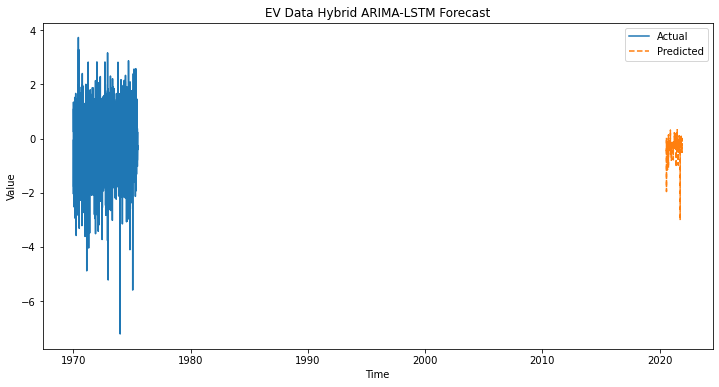

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Epoch 1/50


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0203
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9610
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0451
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9306
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9923
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9896
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9638
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9782
Epoch 9/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8862
Epoch 10/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0083
Epoch 11/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9154
Epoch 12/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0269
Epoch 13/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0209
Epoch 14/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9661
Epoch 15/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8569


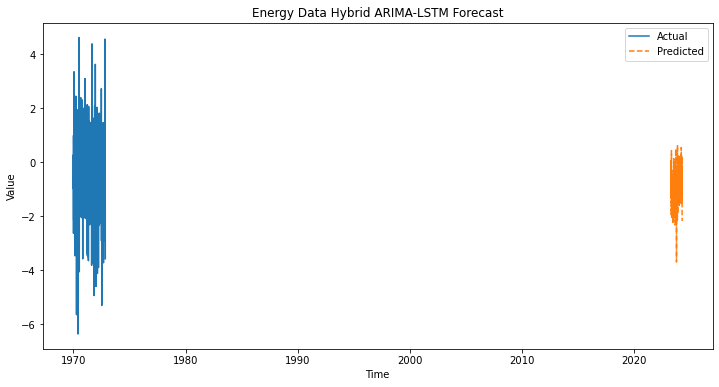

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

Epoch 1/50


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5604
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6267
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3802
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6860
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6058
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3274
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5072
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6577
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5742
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4129
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5168
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4032
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6852
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5253
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6316
Epoch 16/50
26/26 ━━━━━━━━━━━━

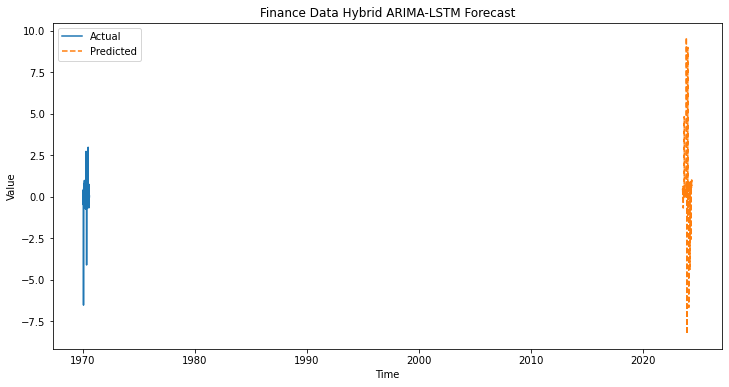

In [ ]:
#### import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Function to train the best ARIMA model
def train_best_arima_model(df, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(df, order=order)
                    model_fit = model.fit()
                    aic = model_fit.aic
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                except:
                    continue
    return ARIMA(df, order=best_cfg).fit()

# Function to train the LSTM model
def train_lstm_model(X_train, y_train, input_dim, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(input_dim, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Function to create windowed data for LSTM
def create_windowed_data(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[i:i+window_size])
        y.append(df[i+window_size])
    return np.array(X), np.array(y)

# Function to evaluate and plot the model
def evaluate_hybrid_model(y_true, y_pred, title):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    accuracy = 100 - np.mean(np.abs((y_true - y_pred) / y_true) * 100)

    print(f"{title} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}, Accuracy: {accuracy:.2f}%")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Function to run hybrid model
def run_hybrid_model(df, feature, p_values, d_values, q_values, title):
    data_for_arima = df[[feature]].dropna()
    
    # ARIMA model
    arima_model = train_best_arima_model(data_for_arima, p_values, d_values, q_values)
    arima_pred = arima_model.predict(start=1, end=len(data_for_arima) - 1)
    residuals = data_for_arima.iloc[1:][feature] - arima_pred

    # ANN model for residuals
    scaler = StandardScaler()
    residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))
    window_size = 5  # Adjustable window size for ANN input
    X, y = create_windowed_data(residuals_scaled, window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lstm_model = train_lstm_model(X_train, y_train, input_dim=window_size)
    ann_pred = lstm_model.predict(X_test)

    # Adjusting arima_pred to have the same length as ann_pred
    arima_pred_trimmed = arima_pred[-len(ann_pred):]

    # Combine ARIMA and ANN predictions
    combined_pred = arima_pred_trimmed + ann_pred.flatten()
    evaluate_hybrid_model(y_test.flatten(), combined_pred, title)


# Run hybrid models with tuned ARIMA and LSTM on datasets
# Specify p, d, q values to search
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3, 4, 5]

# Example usage
run_hybrid_model(ev_data, 'mean_xco2', p_values, d_values, q_values, "EV Data Hybrid ARIMA-LSTM Forecast")
run_hybrid_model(e_data, 'Consumption', p_values, d_values, q_values, "Energy Data Hybrid ARIMA-LSTM Forecast")
run_hybrid_model(f_data, 'Close/Last', p_values, d_values, q_values, "Finance Data Hybrid ARIMA-LSTM Forecast")

In [ ]:
print ("hysam")

hysam


In [ ]:
import sqlite3

In [1]:
#### import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Function to train the best ARIMA model
def train_best_arima_model(df, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(df, order=order)
                    model_fit = model.fit()
                    aic = model_fit.aic
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                except:
                    continue
    return ARIMA(df, order=best_cfg).fit()

# Function to train the LSTM model
def train_lstm_model(X_train, y_train, input_dim, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(input_dim, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Function to create windowed data for LSTM
def create_windowed_data(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[i:i+window_size])
        y.append(df[i+window_size])
    return np.array(X), np.array(y)

# Function to evaluate and plot the model
def evaluate_hybrid_model(y_true, y_pred, title):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    accuracy = 100 - np.mean(np.abs((y_true - y_pred) / y_true) * 100)

    print(f"{title} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}, Accuracy: {accuracy:.2f}%")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Function to run hybrid model
def run_hybrid_model(df, feature, p_values, d_values, q_values, title):
    data_for_arima = df[[feature]].dropna()
    
    # ARIMA model
    arima_model = train_best_arima_model(data_for_arima, p_values, d_values, q_values)
    arima_pred = arima_model.predict(start=1, end=len(data_for_arima) - 1)
    residuals = data_for_arima.iloc[1:][feature] - arima_pred

    # ANN model for residuals
    scaler = StandardScaler()
    residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))
    window_size = 5  # Adjustable window size for ANN input
    X, y = create_windowed_data(residuals_scaled, window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lstm_model = train_lstm_model(X_train, y_train, input_dim=window_size)
    ann_pred = lstm_model.predict(X_test)

    # Adjusting arima_pred to have the same length as ann_pred
    arima_pred_trimmed = arima_pred[-len(ann_pred):]

    # Combine ARIMA and ANN predictions
    combined_pred = arima_pred_trimmed + ann_pred.flatten()
    evaluate_hybrid_model(y_test.flatten(), combined_pred, title)


# Run hybrid models with tuned ARIMA and LSTM on datasets
# Specify p, d, q values to search
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3, 4, 5]

# Example usage
run_hybrid_model(ev_data, 'mean_xco2', p_values, d_values, q_values, "EV Data Hybrid ARIMA-LSTM Forecast")
run_hybrid_model(e_data, 'Consumption', p_values, d_values, q_values, "Energy Data Hybrid ARIMA-LSTM Forecast")
run_hybrid_model(f_data, 'Close/Last', p_values, d_values, q_values, "Finance Data Hybrid ARIMA-LSTM Forecast")

NameError: name 'ev_data' is not defined

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0479
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9652
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9398
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9957
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9454
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9686
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9810
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0259
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9794
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9962
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0541
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9674
Epoch 13/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0061
Epoch 14/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9705
Epoch 15/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

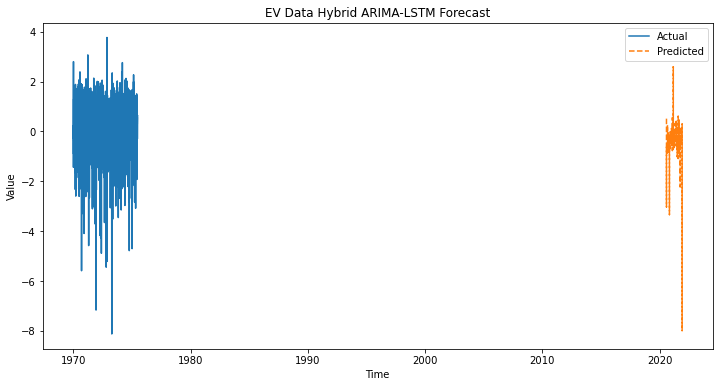

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

Epoch 1/50


C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9988
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0497
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0342
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8947
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0008
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9291
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9471
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9894
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9514
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9295
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0121
Epoch 12/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9621
Epoch 13/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9565
Epoch 14/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9908
Epoch 15/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9689


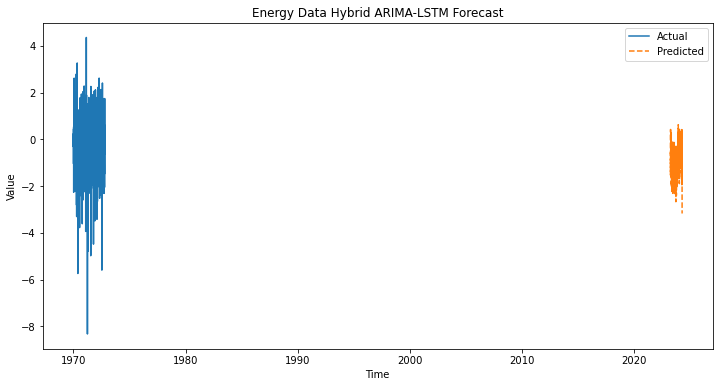

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hysam\a

Epoch 1/50


C:\Users\hysam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hysam\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3446
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6497
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4303
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4234
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5998
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6812
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4257
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6613
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7123
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6712
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4313
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6200
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5385
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4502
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3535
Epoch 16/50
26/26 ━━━━━━━━━━━━

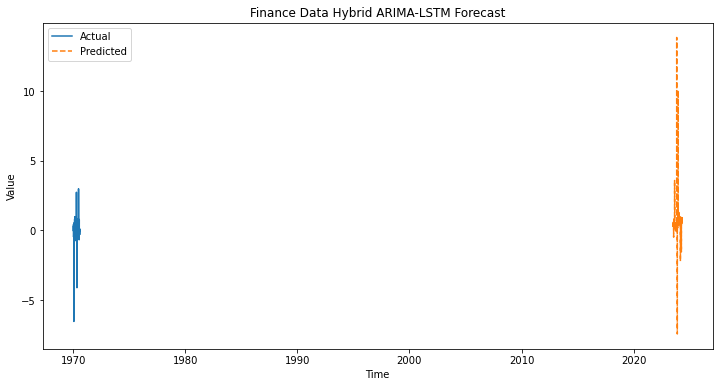

In [9]:
import os

# Function to evaluate and plot the model
def evaluate_hybrid_model(y_true, y_pred, title, filename=None):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    accuracy = 100 - np.mean(np.abs((y_true - y_pred) / y_true) * 100)

    print(f"{title} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}, Accuracy: {accuracy:.2f}%")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    
    # Save plot as PNG if filename is provided
    if filename:
        plt.savefig(filename)
    
    plt.show()

# Function to run hybrid model
def run_hybrid_model(df, feature, p_values, d_values, q_values, title, filename=None):
    data_for_arima = df[[feature]].dropna()
    
    # ARIMA model
    arima_model = train_best_arima_model(data_for_arima, p_values, d_values, q_values)
    arima_pred = arima_model.predict(start=1, end=len(data_for_arima) - 1)
    residuals = data_for_arima.iloc[1:][feature] - arima_pred

    # ANN model for residuals
    scaler = StandardScaler()
    residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))
    window_size = 5  # Adjustable window size for ANN input
    X, y = create_windowed_data(residuals_scaled, window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lstm_model = train_lstm_model(X_train, y_train, input_dim=window_size)
    ann_pred = lstm_model.predict(X_test)

    # Adjusting arima_pred to have the same length as ann_pred
    arima_pred_trimmed = arima_pred[-len(ann_pred):]

    # Combine ARIMA and ANN predictions
    combined_pred = arima_pred_trimmed + ann_pred.flatten()
    evaluate_hybrid_model(y_test.flatten(), combined_pred, title, filename)


# Run hybrid models with tuned ARIMA and LSTM on datasets
# Specify p, d, q values to search
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3, 4, 5]

# Example usage with filename specified
run_hybrid_model(ev_data, 'mean_xco2', p_values, d_values, q_values, "EV Data Hybrid ARIMA-LSTM Forecast", "ev_data_forecast.png")
run_hybrid_model(e_data, 'Consumption', p_values, d_values, q_values, "Energy Data Hybrid ARIMA-LSTM Forecast", "e_data_forecast.png")
run_hybrid_model(f_data, 'Close/Last', p_values, d_values, q_values, "Finance Data Hybrid ARIMA-LSTM Forecast", "f_data_forecast.png")
